In [2]:
# import tensorflow as tf
# import keras
import pandas as pd
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm_notebook
import seaborn as sns

from sklearn.model_selection import train_test_split

import pickle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square, opening, remove_small_objects
from skimage.color import label2rgb
import pandas as pd

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import adapted_rand_error, hausdorff_distance, mean_squared_error, peak_signal_noise_ratio, variation_of_information
from skimage.feature.texture import greycoprops
from skimage.filters import sobel, sobel_h, sobel_v
from skimage.feature import hog
from skimage import data, exposure

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from skimage.filters import sobel, sobel_h, sobel_v
from skimage.feature import hog, canny, corner_fast

import sys
from time import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from skimage.filters import threshold_yen

from math import sqrt
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

import cv2
import rasterio
import gc

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import *
import glob
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys

from tensorflow.keras.models import Model
from tensorflow.python.keras.applications import resnet, resnet_v2
from tensorflow.keras.optimizers import Adam

In [4]:
# files_vv = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/large_scale/npy/*vv.npy')
# files_vh = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/large_scale/npy/*vh.npy')

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import *
import glob
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_efficientnet_v2 import EfficientNetV2S
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import Progbar

In [6]:
def read_npy(f):
    arr = np.load(f.numpy().decode(), allow_pickle=True)[()]
    x = arr['img'][0]
    y = arr['label'][0]
    
    x_shape = x.shape
    y_shape = y.shape
    
    x = tf.constant(x, dtype=tf.float32, shape=x_shape)
    y = tf.constant(y, dtype=tf.float32, shape=y_shape)
    
    return x, y

In [7]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'img'        : tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'img_height' : tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
        'img_width'  : tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
        'label'      : tf.io.FixedLenSequenceFeature([], tf.float32, allow_missing=True),
        'scene_id'   : tf.io.FixedLenSequenceFeature([], tf.string, allow_missing=True),
        'detect_scene_row' :  tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
        'detect_scene_column' : tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True),
    }
    
    example = tf.io.parse_single_example(example, tfrec_format)
    
    
    h = example['img_height']
    w = example['img_width']
    img = example['img']
    label = example['label']
    id = example['scene_id']
    r = example['detect_scene_row']
    c = example['detect_scene_column']
    
    img = tf.reshape(img, shape=(h[0],w[0],3))
    
    img.set_shape((64,64,3))
    
    return img, label, id, r, c

In [8]:
def set_shape_ds(x, y, BATCH_SIZE):
    x = x.set_shape((BATCH_SIZE, 64,64,3))
    y = y.set_shape((BATCH_SIZE, 1))
    return x, y

In [9]:
def create_datagen(files, shuffle = False, repeat = False, batch_size=16, aug=False, progressive_training=False):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=tf.data.AUTOTUNE)
    
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*2)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    ds = ds.map(lambda example: read_labeled_tfrecord(example), 
                    num_parallel_calls=tf.data.AUTOTUNE)      
    
    if aug:
        ds = ds.batch(1)
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.unbatch()

    if progressive_training:
        ds = ds.map(lambda x, y: train_process(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    
    ds = ds.batch(batch_size)
    
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    ds = ds.apply(tf.data.experimental.ignore_errors())
    
    return ds

In [10]:
files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/*')
files.extend(glob.glob('/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_med/*'))

In [11]:
files

['/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_8.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_5.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_15.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_4.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_14.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_6.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_13.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_12.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_7.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_1.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_9.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/train/tfrecords_high/train_shard_0.tfrec',


In [12]:
all_files=0
npy_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/train/npy_med/*')
all_files+=len(npy_files)
npy_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/train/npy_high/*')
all_files+=len(npy_files)

In [13]:
all_files

53067

In [13]:
BATCH_SIZE = 1
MIX_UP_P=0.1
SHARD_SIZE=1000

#training generator
train_gen = create_datagen(files,
                           shuffle=False,
                           repeat=False,
                           batch_size=BATCH_SIZE,
                           aug=False,
                           progressive_training=False)

training_steps = int(np.ceil((len(files)*SHARD_SIZE)/BATCH_SIZE))

In [9]:
# df_sub = pd.read_csv('./subs/external/sub_102721/sub1.csv')
df_sub = pd.read_csv('./subs/internal/sub9.csv')
img_ids = sorted(np.unique(df_sub.scene_id.values))
df_sub.head()

,detect_scene_row,detect_scene_column,scene_id,is_vessel,is_fishing,vessel_length_m
0,17106.0,6422.0,b5a234fb59c7534bp,True,True,15
1,16958.0,6594.0,b5a234fb59c7534bp,True,True,15
2,18314.0,25546.0,cf10d2ab427c6aedp,False,False,100
3,19179.0,24530.0,cf10d2ab427c6aedp,True,False,100
4,18653.0,25019.0,cf10d2ab427c6aedp,True,False,100


In [10]:
# pbar = Progbar(all_files)
pbar = Progbar(len(img_ids))

# X_tr = pd.DataFrame(index=range(all_files), dtype=np.float64)
X_tr = pd.DataFrame(index=range(df_sub.shape[0]), dtype=np.float64)

# y_data = np.zeros((all_files, 3))

base_path = '/tf/media/ryan/bigboi/datasets/xview3/public/src/'
j = 0
ids=[]

for id in img_ids:
    
    df_filtered = df_sub[df_sub['scene_id']==id]
    
#     print(base_path+id+'/VV_dB.tif')
#     x_vv_full = rasterio.open(base_path+id+'/VV_dB.tif').read(1)
#     x_vv_full[x_vv_full==-32768.0] = 0.0
#     x_vv_full[x_vv_full!=0.0] = x_vv_full[x_vv_full!=0.0] - np.amin(x_vv_full)
    
    x_vh_full = rasterio.open(base_path+id+'/VH_dB.tif').read(1)
    x_vh_full[x_vh_full==-32768.0] = 0.0
    x_vh_full[x_vh_full!=0.0] = x_vh_full[x_vh_full!=0.0] - np.amin(x_vh_full)
    
    #meta data
    bath_path = base_path+id+'/bathymetry.tif'
    wind_dir_path = base_path+id+'/owiWindDirection.tif'
    wind_qual_path = base_path+id+'/owiWindQuality.tif'
    wind_speed_path = base_path+id+'/owiWindSpeed.tif'
    
    bath_img = rasterio.open(bath_path).read(1)
    bath_img[bath_img==-32768.0] = 0.0
    
    wind_dir_img = rasterio.open(wind_dir_path).read(1)
    wind_dir_img[wind_dir_img==-32768.0] = 0.0
    
    wind_qual_img = rasterio.open(wind_qual_path).read(1)
    wind_qual_img[wind_qual_img==-32768.0] = 0.0
    
    wind_speed_img = rasterio.open(wind_speed_path).read(1)
    wind_speed_img[wind_speed_img==-32768.0] = 0.0
    
#     x_vv = x.numpy()[0,:,:,0]
#     x_vh = x.numpy()[0,:,:,1]
    
    for r, c in zip(df_filtered.detect_scene_row.values, df_filtered.detect_scene_column.values):
    
        ids.append(id)
        r = int(r)
        c = int(c)
    
#         x_vv = x_vv_full[r-32:r+32,c-32:c+32]
        x_vh = x_vh_full[r-32:r+32,c-32:c+32]
    
#         plt.figure(figsize=(10,10))
#         plt.subplot(1,2,1)
#         plt.imshow(x_vv)
#         plt.subplot(1,2,2)
#         plt.imshow(x_vv)
#         plt.show()
        
#         X_tr.loc[j, f'max_vv'] = np.amax(x_vv)
#         X_tr.loc[j, f'min_vv'] = np.amin(x_vv)
#         X_tr.loc[j, f'std_vv'] = np.std(x_vv)
#         X_tr.loc[j, f'mean_vv'] = np.mean(x_vv)
#         X_tr.loc[j, f'median_vv'] = np.median(x_vv)

        X_tr.loc[j, f'max_vh'] = np.amax(x_vh)
        X_tr.loc[j, f'min_vh'] = np.amin(x_vh)
        X_tr.loc[j, f'std_vh'] = np.std(x_vh)
        X_tr.loc[j, f'mean_vh'] = np.mean(x_vh)
        X_tr.loc[j, f'median_vh'] = np.median(x_vh)

#         X_tr.loc[j, f'ssim'] = ssim(x_vv, x_vh, data_range=100.0)
#         X_tr.loc[j, f'ssim_weighted'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=True)
#         X_tr.loc[j, f'ssim_3'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=3)
#         X_tr.loc[j, f'ssim_7'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=7)
#         X_tr.loc[j, f'ssim_21'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=21)
#         X_tr.loc[j, f'ssim_31'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=31)
#         X_tr.loc[j, f'psnr'] = peak_signal_noise_ratio(x_vv, x_vh, data_range=100.0)

        #edges
#         X_tr.loc[j, f'sum_sobel_vv'] = np.sum(sobel(x_vv))
        X_tr.loc[j, f'sum_sobel_vh'] = np.sum(sobel(x_vh))
#         X_tr.loc[j, f'sum_sobel_v_vv'] = np.sum(sobel_v(x_vv))
        X_tr.loc[j, f'sum_sobel_v_vh'] = np.sum(sobel_v(x_vh))
#         X_tr.loc[j, f'sum_sobel_h_vv'] = np.sum(sobel_h(x_vv))
        X_tr.loc[j, f'sum_sobel_h_vh'] = np.sum(sobel_h(x_vh))

        #simple histogram
#         hist = np.histogram(x_vv, bins=20, range=(0,50))[0]
#         for h in range(hist.shape[0]):
#             X_tr.loc[j, f'hist_vv_bin_{h}'] = hist[h]

        hist = np.histogram(x_vh, bins=20, range=(0,50))[0]
        for h in range(hist.shape[0]):
            X_tr.loc[j, f'hist_vh_bin_{h}'] = hist[h]

        #HOG
#         hog_image = hog(x_vv, orientations=8, pixels_per_cell=(2,2),
#                         cells_per_block=(1, 1), visualize=False)

#         hog_ = np.histogram(hog_image, bins=20, range=(0,1))[0]
#         for h in range(hog_.shape[0]):
#             X_tr.loc[j, f'hog_vv_bin_{h}'] = hog_[h]

        hog_image = hog(x_vh, orientations=8, pixels_per_cell=(2,2),
                        cells_per_block=(1, 1), visualize=False)
        hog_ = np.histogram(hog_image, bins=20, range=(0,1))[0]
        for h in range(hog_.shape[0]):
            X_tr.loc[j, f'hog_vh_bin_{h}'] = hog_[h]
    
        #canny
#         can_vh = canny(x_vh)
#         can_vv = canny(x_vv)
#         X_tr.loc[j, f'canny_vv_vh_AND'] = np.sum(np.logical_and(can_vv, can_vh))/(64*64)

        #corners
#         corner_vv = corner_fast(x_vv)
#         hist = np.histogram(corner_vv, bins=20, range=(0,200))[0]
#         for h in range(hist.shape[0]):
#             X_tr.loc[j, f'corner_hist_vv_bin_{h}'] = hist[h]

        corner_vh = corner_fast(x_vh)
        hist = np.histogram(corner_vh, bins=20, range=(0,200))[0]
        for h in range(hist.shape[0]):
            X_tr.loc[j, f'corner_hist_vh_bin_{h}'] = hist[h]

        #region based
#         mask = x_vv > threshold_yen(x_vv)
#         label_img = label(mask)
#         areas = [region.area for region in regionprops(label_img)]
#         max_area = np.amax(areas)

#         for region in regionprops(label_img):
#             if region.area == max_area:
#                 X_tr.loc[j, f'vv_area'] = region.area
#                 X_tr.loc[j, f'vv_bbox_area'] = region.bbox_area
#                 X_tr.loc[j, f'vv_convex_area'] = region.convex_area
#                 X_tr.loc[j, f'vv_eccentricity'] = region.eccentricity
#                 X_tr.loc[j, f'vv_equivalent_diameter'] = region.equivalent_diameter
#                 X_tr.loc[j, f'vv_euler_number'] = region.euler_number
#                 X_tr.loc[j, f'vv_extent'] = region.extent
#                 X_tr.loc[j, f'vv_feret_diameter_max'] = region.feret_diameter_max
#                 X_tr.loc[j, f'vv_filled_area'] = region.filled_area
#                 X_tr.loc[j, f'vv_inertia_tensor0'] = region.inertia_tensor.ravel()[0]
#                 X_tr.loc[j, f'vv_inertia_tensor1'] = region.inertia_tensor.ravel()[1]
#                 X_tr.loc[j, f'vv_inertia_tensor2'] = region.inertia_tensor.ravel()[2]
#                 X_tr.loc[j, f'vv_inertia_tensor3'] = region.inertia_tensor.ravel()[3]
#                 X_tr.loc[j, f'vv_inertia_tensor_eigvals0'] = region.inertia_tensor_eigvals[0]
#                 X_tr.loc[j, f'vv_inertia_tensor_eigvals1'] = region.inertia_tensor_eigvals[1]
#                 X_tr.loc[j, f'vv_major_axis_length'] = region.major_axis_length
#                 X_tr.loc[j, f'vv_minor_axis_length'] = region.minor_axis_length
#                 X_tr.loc[j, f'vv_orientation'] = region.orientation
#                 X_tr.loc[j, f'vv_perimeter'] = region.perimeter
#                 X_tr.loc[j, f'vv_perimeter_crofton'] = region.perimeter_crofton
#                 X_tr.loc[j, f'vv_solidity'] = region.solidity

        mask = x_vh > threshold_yen(x_vh)
        label_img = label(mask)
        areas = [region.area for region in regionprops(label_img)]
        max_area = np.amax(areas)

        for region in regionprops(label_img):
            if region.area == max_area:
                X_tr.loc[j, f'vh_area'] = region.area
                X_tr.loc[j, f'vh_bbox_area'] = region.bbox_area
                X_tr.loc[j, f'vh_convex_area'] = region.convex_area
                X_tr.loc[j, f'vh_eccentricity'] = region.eccentricity
                X_tr.loc[j, f'vh_equivalent_diameter'] = region.equivalent_diameter
                X_tr.loc[j, f'vh_euler_number'] = region.euler_number
                X_tr.loc[j, f'vh_extent'] = region.extent
                X_tr.loc[j, f'vh_feret_diameter_max'] = region.feret_diameter_max
                X_tr.loc[j, f'vh_filled_area'] = region.filled_area
                X_tr.loc[j, f'vh_inertia_tensor0'] = region.inertia_tensor.ravel()[0]
                X_tr.loc[j, f'vh_inertia_tensor1'] = region.inertia_tensor.ravel()[1]
                X_tr.loc[j, f'vh_inertia_tensor2'] = region.inertia_tensor.ravel()[2]
                X_tr.loc[j, f'vh_inertia_tensor3'] = region.inertia_tensor.ravel()[3]
                X_tr.loc[j, f'vh_inertia_tensor_eigvals0'] = region.inertia_tensor_eigvals[0]
                X_tr.loc[j, f'vh_inertia_tensor_eigvals1'] = region.inertia_tensor_eigvals[1]
                X_tr.loc[j, f'vh_major_axis_length'] = region.major_axis_length
                X_tr.loc[j, f'vh_minor_axis_length'] = region.minor_axis_length
                X_tr.loc[j, f'vh_orientation'] = region.orientation
                X_tr.loc[j, f'vh_perimeter'] = region.perimeter
                X_tr.loc[j, f'vh_perimeter_crofton'] = region.perimeter_crofton
                X_tr.loc[j, f'vh_solidity'] = region.solidity

        #ancilary data
    
        meta_row = r // 50
        meta_col = c // 50
        
        X_tr.loc[j, f'bathymetry'] = bath_img[meta_row, meta_col]
        X_tr.loc[j, f'owiWindDirection'] = wind_dir_img[meta_row, meta_col]
        X_tr.loc[j, f'owiWindQuality'] = wind_qual_img[meta_row, meta_col]
        X_tr.loc[j, f'owiWindSpeed'] = wind_speed_img[meta_row, meta_col]

        j += 1
    
    x_vh_full = None
    del(x_vh_full)
    del(bath_img)
    del(wind_dir_img)
    del(wind_qual_img)
    del(wind_speed_img)
    
    gc.collect()
    
    pbar.add(1)
    
#     break

  6/150 [>.............................] - ETA: 3:38:11

KeyboardInterrupt: 

In [123]:
df_out_new = pd.DataFrame(
    columns=(
        "detect_scene_row",
        "detect_scene_column",
        "scene_id",
        "is_vessel",
        "is_fishing",
        "vessel_length_m",
    )
)
j=0
c=0

bath_values = X_tr.bathymetry.values

for id in img_ids:
    
    df_filtered = df_sub[df_sub['scene_id']==id]
    
    for r in range(df_filtered.shape[0]):
        
        if bath_values[j] < 1.0:
        
            df_out_new.loc[c, 'detect_scene_row'] = df_filtered['detect_scene_row'].values[r]
            df_out_new.loc[c, 'detect_scene_column'] = df_filtered['detect_scene_column'].values[r]
            df_out_new.loc[c, 'scene_id'] = df_filtered['scene_id'].values[r]

    #         pred_class = np.argmax(y_pred[j])
            pred_class = y_pred[j]

            if pred_class == 0:
                df_out_new.loc[c, 'is_vessel'] = False
                df_out_new.loc[c, 'is_fishing'] = False
                df_out_new.loc[c, 'vessel_length_m'] = 100.0
            elif pred_class == 1:
                df_out_new.loc[c, 'is_vessel'] = True
                df_out_new.loc[c, 'is_fishing'] = False
                df_out_new.loc[c, 'vessel_length_m'] = 100.0
            elif pred_class == 2:
                df_out_new.loc[c, 'is_vessel'] = True
                df_out_new.loc[c, 'is_fishing'] = True
                df_out_new.loc[c, 'vessel_length_m'] = 20.0

            c+=1
                
        j+=1
    
#     break

In [124]:
df_out_new

,detect_scene_row,detect_scene_column,scene_id,is_vessel,is_fishing,vessel_length_m
0,9260.0,2977.0,02649c5fc4f85dadp,False,False,100.0
1,9259.0,2977.0,02649c5fc4f85dadp,False,False,100.0
2,9166.0,2990.0,02649c5fc4f85dadp,False,False,100.0
3,17648.0,10117.0,02649c5fc4f85dadp,False,False,100.0
4,8681.0,14294.0,02649c5fc4f85dadp,False,False,100.0
...,...,...,...,...,...,...
28801,8983.0,10225.0,ffc117c4c9e3e523p,False,False,100.0
28802,8996.0,9591.0,ffc117c4c9e3e523p,True,True,20.0
28803,9617.0,9971.0,ffc117c4c9e3e523p,False,False,100.0
28804,11653.0,19126.0,ffc117c4c9e3e523p,True,True,20.0


In [13]:
# df_out_new

In [125]:
df_out_new.to_csv('./subs/external/sub_102921/sub_0_lgb.csv', index=False)

In [112]:
X_tr.head()

,max_vh,min_vh,std_vh,mean_vh,median_vh,sum_sobel_vh,sum_sobel_v_vh,sum_sobel_h_vh,hist_vh_bin_0,hist_vh_bin_1,...,vh_major_axis_length,vh_minor_axis_length,vh_orientation,vh_perimeter,vh_perimeter_crofton,vh_solidity,bathymetry,owiWindDirection,owiWindQuality,owiWindSpeed
0,52.382812,22.921875,2.317933,32.491707,32.484375,6160.144312,26.68750,302.81250,0.0,0.0,...,6.416532,6.219185,0.297705,18.485281,20.206663,0.939394,28.890625,0.00,0.0,0.000000
1,41.972656,13.437500,2.120825,23.133125,23.140625,5798.021650,33.31250,35.43750,0.0,0.0,...,11.542317,7.216621,-0.592731,29.798990,30.932731,0.941176,-0.918457,0.00,0.0,0.000000
2,41.972656,13.437500,2.118943,23.130577,23.125000,5804.412149,24.21875,103.03125,0.0,0.0,...,11.542317,7.216621,-0.592731,29.798990,30.932731,0.941176,-0.918457,0.00,0.0,0.000000
3,36.117188,15.093750,1.670801,23.076561,23.101562,5755.037336,-73.96875,120.46875,0.0,0.0,...,9.894286,5.064218,0.244396,20.278175,26.125057,0.878049,0.007725,0.00,0.0,0.000000
4,47.267578,13.375000,3.387480,23.078751,22.656250,6278.807091,94.46875,24.71875,0.0,0.0,...,22.750969,13.266461,0.463650,63.148232,64.642264,0.854962,-55.906250,136.75,3.0,3.253906


In [83]:
X_tr = pd.read_csv('./boosting/X_tr_public_lb_yolov5m_preds.csv').iloc[:,1:]

In [84]:
X_tr

,max_vh,min_vh,std_vh,mean_vh,median_vh,sum_sobel_vh,sum_sobel_v_vh,sum_sobel_h_vh,hist_vh_bin_0,hist_vh_bin_1,...,vh_major_axis_length,vh_minor_axis_length,vh_orientation,vh_perimeter,vh_perimeter_crofton,vh_solidity,bathymetry,owiWindDirection,owiWindQuality,owiWindSpeed
0,52.382812,22.921875,2.317933,32.491707,32.484375,6160.144312,26.68750,302.81250,0.0,0.0,...,6.416532,6.219185,0.297705,18.485281,20.206663,0.939394,28.890625,0.000000,0.0,0.000000
1,41.972656,13.437500,2.120825,23.133125,23.140625,5798.021650,33.31250,35.43750,0.0,0.0,...,11.542317,7.216621,-0.592731,29.798990,30.932731,0.941176,-0.918457,0.000000,0.0,0.000000
2,41.972656,13.437500,2.118943,23.130577,23.125000,5804.412149,24.21875,103.03125,0.0,0.0,...,11.542317,7.216621,-0.592731,29.798990,30.932731,0.941176,-0.918457,0.000000,0.0,0.000000
3,36.117188,15.093750,1.670801,23.076561,23.101562,5755.037336,-73.96875,120.46875,0.0,0.0,...,9.894286,5.064218,0.244396,20.278175,26.125057,0.878049,0.007725,0.000000,0.0,0.000000
4,47.267578,13.375000,3.387480,23.078751,22.656250,6278.807091,94.46875,24.71875,0.0,0.0,...,22.750969,13.266461,0.463650,63.148232,64.642264,0.854962,-55.906250,136.750000,3.0,3.253906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31136,43.648438,15.093750,2.038976,22.670109,22.687500,5324.408464,122.75000,-15.15625,0.0,0.0,...,13.371777,10.189321,0.482739,38.384776,39.072567,0.902655,-42.000000,23.359375,3.0,3.742188
31137,44.292969,13.500000,1.951738,21.791470,21.875000,5585.562856,10.09375,15.96875,0.0,0.0,...,11.636301,6.195918,0.003416,27.485281,31.028016,0.800000,-40.562500,25.578125,3.0,3.599609
31138,39.898438,13.281250,1.982499,22.806242,22.796875,5327.947579,83.12500,75.06250,0.0,0.0,...,13.843533,9.470445,0.380403,39.213203,39.857965,0.862385,-41.250000,30.031250,3.0,4.312500
31139,33.898438,8.875000,1.635026,20.318647,20.375000,5449.566720,146.78125,-57.50000,0.0,0.0,...,7.374269,4.220444,0.075899,16.242641,18.080506,1.000000,-51.406250,13.109375,3.0,4.593750


In [ ]:
lgm_model0 = lgb.Booster(model_file='./boosting/k_fold/lgbm_fold0.txt')
lgm_model1 = lgb.Booster(model_file='./boosting/k_fold/lgbm_fold1.txt')
lgm_model2 = lgb.Booster(model_file='./boosting/k_fold/lgbm_fold2.txt')
lgm_model3 = lgb.Booster(model_file='./boosting/k_fold/lgbm_fold3.txt')
lgm_model4 = lgb.Booster(model_file='./boosting/k_fold/lgbm_fold4.txt')

model0_best_thres = [0.47611290155498504, 0.3137128139120775, 0.4887825418543462]
model1_best_thres = [0.42961603626106687, 0.36163008864997276, 0.45747393151345767]
model2_best_thres = [0.4777925039552873, 0.32645991040980965, 0.5028331038031579]
model3_best_thres = [0.47964815772510244, 0.3689364924802241, 0.44812842100683536]
model4_best_thres = [0.4338617144468921, 0.3546744966513995, 0.4746763538525655]


In [95]:
y_pred0 = np.expand_dims((lgm_model0.predict(X_tr) > model0_best_thres).astype(np.int),axis=-1)
y_pred1 = np.expand_dims((lgm_model1.predict(X_tr) > model1_best_thres).astype(np.int),axis=-1)
y_pred2 = np.expand_dims((lgm_model2.predict(X_tr) > model2_best_thres).astype(np.int),axis=-1)
y_pred3 = np.expand_dims((lgm_model3.predict(X_tr) > model3_best_thres).astype(np.int),axis=-1)
y_pred4 = np.expand_dims((lgm_model4.predict(X_tr) > model4_best_thres).astype(np.int),axis=-1)

In [99]:
y_pred0.shape

(31141, 3, 1)

In [102]:
pred_concat = np.concatenate((y_pred0,y_pred1,y_pred2,y_pred3,y_pred4), axis=-1)

#vote over all 5-folds
pred_sum = np.sum(pred_concat, axis=-1)

In [104]:
pred_sum

array([[5, 0, 0],
       [5, 4, 0],
       [5, 4, 0],
       ...,
       [5, 0, 0],
       [0, 0, 5],
       [5, 0, 0]])

In [108]:
y_pred = []
for p in pred_sum:
    if np.sum(p) == 0:
        y_pred.append(-1)
    else:
        y_pred.append(np.argmax(p))

In [ ]:
lgm_model0 = lgb.Booster(model_file='./boosting/k_fold/lgbm_fold0.txt')
lgm_model1 = lgb.Booster(model_file='./boosting/k_fold/lgbm_fold1.txt')
lgm_model2 = lgb.Booster(model_file='./boosting/k_fold/lgbm_fold2.txt')
lgm_model3 = lgb.Booster(model_file='./boosting/k_fold/lgbm_fold3.txt')
lgm_model4 = lgb.Booster(model_file='./boosting/k_fold/lgbm_fold4.txt')

model0_best_thres = [0.47611290155498504, 0.3137128139120775, 0.4887825418543462]
model1_best_thres = [0.42961603626106687, 0.36163008864997276, 0.45747393151345767]
model2_best_thres = [0.4777925039552873, 0.32645991040980965, 0.5028331038031579]
model3_best_thres = [0.47964815772510244, 0.3689364924802241, 0.44812842100683536]
model4_best_thres = [0.4338617144468921, 0.3546744966513995, 0.4746763538525655]

for i, (r, c) in enumerate(zip(df_filtered.detect_scene_row.values, df_filtered.detect_scene_column.values)):

    r = int(r)
    c = int(c)

    print(r, c)
    
    x_vh = x_vh_full[r-32:r+32,c-32:c+32]
    
    y_pred0 = lgm_model0.predict(X_tr.iloc[i])[0] > model0_best_thres
    y_pred1 = lgm_model1.predict(X_tr.iloc[i])[0] > model1_best_thres
    y_pred2 = lgm_model2.predict(X_tr.iloc[i])[0] > model2_best_thres
    y_pred3 = lgm_model3.predict(X_tr.iloc[i])[0] > model3_best_thres
    y_pred4 = lgm_model4.predict(X_tr.iloc[i])[0] > model4_best_thres
    
    pred_concat = np.array([y_pred0.astype(np.int), 
                 y_pred1.astype(np.int),
                 y_pred2.astype(np.int),
                 y_pred3.astype(np.int),
                 y_pred4.astype(np.int)])
    
    #vote over all 5-folds
    pred_sum = np.sum(pred_concat, axis=0)
    if np.sum(pred_sum) == 0:
        final_pred = -1
    else:
        final_pred = np.argmax(np.sum(pred_concat, axis=0))
        
    print(f"BATHYMETRY = {X_tr.iloc[i].bathymetry}")
    print(f"AREA = {X_tr.iloc[i].vh_area}")
    
    if X_tr.iloc[i].bathymetry > 0:
        pred_class = 'NOTHING'
    else:
        if final_pred == 0:
            pred_class = 'Non-vessel'
        elif final_pred == 1:
            pred_class = 'Vessel'
        elif final_pred == 2:
            pred_class = 'Fishing-vessel'
        else:
            pred_class = 'NOTHING'
    
    if pred_class != "NOTHING":
        plt.figure(figsize=(15,7))
        plt.title(pred_class)
        plt.imshow(x_vh)
        plt.show()

    if i == 75:
        break

In [20]:
lgb_model = lgb.Booster(model_file='./boosting/saved_models/lgbm_full.txt')

In [39]:
y_pred = lgb_model.predict(X_tr)

In [40]:
X_tr['vh_major_axis_length']*20

0        128.330649
1        230.846331
2        230.846331
3        197.885726
4        455.019371
            ...    
31136    267.435533
31137    232.726018
31138    276.870658
31139    147.485388
31140    474.995501
Name: vh_major_axis_length, Length: 31141, dtype: float64

In [12]:
# X_tr.to_csv('./boosting/X_tr_public_lb_yolov5m_preds.csv')

In [12]:
# X_tr.to_csv('./training_features_1.csv')
# np.save('./y_data.npy', y_data, allow_pickle=True)

In [10]:
X_tr_train = pd.read_csv('./training_features_1.csv').iloc[:,1:]
x_meta_features = pd.read_csv('./meta_features.csv').iloc[:,1:]
y_data = np.load('./y_data.npy')

In [11]:
x_meta_features

,bathymetry,owiWindDirection,owiWindQuality,owiWindSpeed
0,-3.171875,225.2500,3.0,3.818359
1,-24.031250,221.7500,3.0,1.943359
2,-8.078125,255.2500,0.0,8.421875
3,-10.140625,270.7500,3.0,2.445312
4,-16.390625,307.0000,0.0,11.609375
...,...,...,...,...
53062,-2576.000000,218.0000,2.0,9.632812
53063,-36.718750,91.9375,2.0,7.687500
53064,-3970.000000,352.0000,3.0,5.378906
53065,-1330.000000,224.1250,3.0,4.296875


In [44]:
X_tr_train = pd.concat(
    [
        X_tr_train.reset_index(drop=True),
        x_meta_features.reset_index(drop=True),
    ],
    axis=1,
    ignore_index=False,
)

In [46]:
X_tr_train = X_tr_train[['max_vh', 'bathymetry', 'owiWindDirection', 'owiWindQuality', 'owiWindSpeed']]

In [47]:
X_tr_train.head()

,max_vh,bathymetry,owiWindDirection,owiWindQuality,owiWindSpeed
0,36.937500,-3.171875,225.25,3.0,3.818359
1,34.687500,-24.031250,221.75,3.0,1.943359
2,43.437500,-8.078125,255.25,0.0,8.421875
3,33.375000,-10.140625,270.75,3.0,2.445312
4,41.804688,-16.390625,307.00,0.0,11.609375


In [31]:
col_oi = []
for i, col in enumerate(X_tr_train.columns.values):
    if ('vv' not in col) and ('ssim' not in col) and ('psnr' not in col) :
        col_oi.append(i)

In [32]:
col_oi

[5,
 6,
 7,
 8,
 9,
 18,
 20,
 22,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189]

In [33]:
X_tr_train = X_tr_train.iloc[:,col_oi]
X_tr_train.head()

,max_vh,min_vh,std_vh,mean_vh,median_vh,sum_sobel_vh,sum_sobel_v_vh,sum_sobel_h_vh,hist_vh_bin_0,hist_vh_bin_1,...,vh_major_axis_length,vh_minor_axis_length,vh_orientation,vh_perimeter,vh_perimeter_crofton,vh_solidity,bathymetry,owiWindDirection,owiWindQuality,owiWindSpeed
0,36.937500,12.15625,2.041302,19.603176,19.453125,5642.118685,15.87500,87.87500,0.0,0.0,...,14.872076,7.943306,-0.254476,37.591883,38.517207,0.834951,-3.171875,225.25,3.0,3.818359
1,34.687500,12.31250,1.584069,22.081829,22.265625,5381.172041,11.78125,-61.09375,0.0,0.0,...,7.738571,5.873238,1.482894,19.899495,21.547421,0.945946,-24.031250,221.75,3.0,1.943359
2,43.437500,9.71875,3.210182,21.004517,20.515625,7843.326083,-69.03125,121.96875,0.0,0.0,...,37.471400,8.164872,0.140653,90.491378,94.980166,0.661417,-8.078125,255.25,0.0,8.421875
3,33.375000,7.90625,1.828051,19.352524,19.359375,4985.241622,-104.18750,-26.81250,0.0,0.0,...,17.387932,6.349252,-0.170180,40.727922,41.294008,0.828283,-10.140625,270.75,3.0,2.445312
4,41.804688,26.84375,1.424176,31.282898,31.140625,3729.688632,-9.78125,-5.31250,0.0,0.0,...,38.517878,4.481341,0.135825,75.077164,76.344300,0.691429,-16.390625,307.00,0.0,11.609375


In [34]:
from sklearn.preprocessing import StandardScaler

In [58]:
scaler = StandardScaler()

X_tr_train_scaled = scaler.fit_transform(X_tr_train)

In [60]:
# X_tr_train_scaled

In [28]:
y_data_class = np.argmax(y_data, axis=1)

X_train, X_val, y_train, y_val = train_test_split(x_meta_features, y_data_class, test_size=0.20, random_state=42)
# plt.bar([0,1,2],np.sum(y_train, axis=0))
# plt.bar([0,1,2],np.sum(y_val, axis=0))

# LGBM developement

### Random searh for hyperparameter optimization

In [29]:
#random search for hyperparameter optimization
param_test ={'num_leaves': sp_randint(50, 225), 
             'min_child_samples': sp_randint(100, 500), 
             'min_data_in_leaf': sp_randint(20,150), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'max_depth': [-1],
             'learning_rate': [0.001],
             'bagging_freq': [2, 3, 4, 5, 6, 7, 10],
             'bagging_fraction': np.linspace(0.6, 0.95, 10),
             'objective':['multiclass'],
             'num_class':[3]}

fit_params={"early_stopping_rounds": 30, 
            "eval_metric" : 'auc_mu', 
            "eval_set" : [(X_val, y_val)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [30]:
#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 50

clf = lgb.LGBMClassifier(max_depth=-1, 
                         random_state=7, 
                         silent=True, 
                         metric='auc_mu', 
                         n_jobs=8, 
                         n_estimators=1000,
                         objective='multiclass',
                         num_class=3)

gs = RandomizedSearchCV(estimator=clf, 
                        param_distributions=param_test, 
                        n_iter=n_HP_points_to_test,
                        scoring='roc_auc_ovr',
                        cv=3,
                        refit=True,
                        random_state=7,
                        verbose=True)

In [31]:
gs.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid's auc_mu: 0.81334
[LightGBM] [Warning] bagging_fraction is set=0.7555555555555555, subsample=0.2693947438719936 will be ignored. Current value: bagging_fraction=0.7555555555555555
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=311 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid's auc_mu: 0.81552
[LightGBM] [Warning] bagging_fraction is set=0.7555555555555555, subsample=0.2693947438719936 will be ignored. Current value: bagging_fraction=0.7555555555555555
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=311 will be ignored. Current value: min_data_in_leaf=123
[LightGB

In [34]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

In [35]:
print(gs.best_params_)

{'bagging_fraction': 0.8722222222222222, 'bagging_freq': 10, 'colsample_bytree': 0.7303258275849434, 'learning_rate': 0.001, 'max_depth': -1, 'min_child_samples': 369, 'min_child_weight': 10.0, 'min_data_in_leaf': 21, 'num_class': 3, 'num_leaves': 81, 'objective': 'multiclass', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.9273459710086789}


### Train with optimal params

(42453,)
(10614,)
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Info] Number of positive: 13353, number of negative: 29100
[LightGBM] [Info] Number of positive: 19092, number of negative: 23361
[LightGBM] [Info] Number of positive: 10008, number of negative: 32445
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

/root/miniconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	training's auc_mu: 0.947193	valid_1's auc_mu: 0.939156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

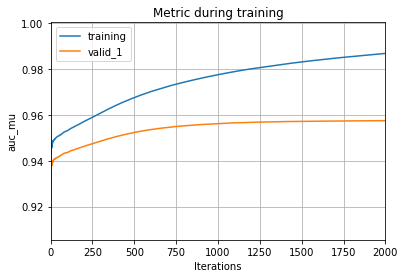

(42453,)
(10614,)
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Info] Number of positive: 13353, number of negative: 29100
[LightGBM] [Info] Number of positive: 19092, number of negative: 23361
[LightGBM] [Info] Number of positive: 10008, number of negative: 32445
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

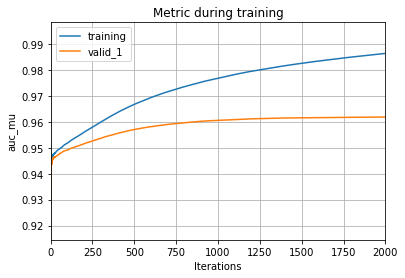

(42454,)
(10613,)
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Info] Number of positive: 13354, number of negative: 29100
[LightGBM] [Info] Number of positive: 19092, number of negative: 23362
[LightGBM] [Info] Number of positive: 10008, number of negative: 32446
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

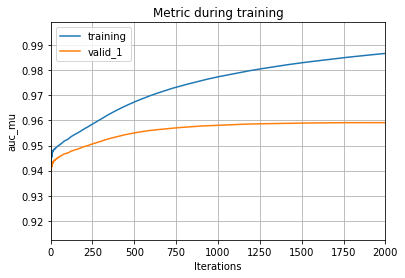

(42454,)
(10613,)
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Info] Number of positive: 13354, number of negative: 29100
[LightGBM] [Info] Number of positive: 19092, number of negative: 23362
[LightGBM] [Info] Number of positive: 10008, number of negative: 32446
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1024
[LightGBM] [Info] Number of data points in the train set

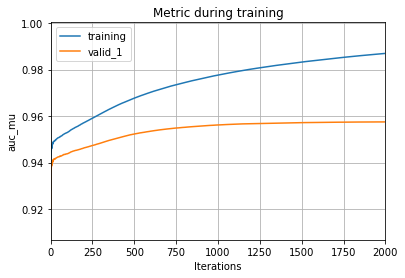

(42454,)
(10613,)
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Info] Number of positive: 13354, number of negative: 29100
[LightGBM] [Info] Number of positive: 19092, number of negative: 23362
[LightGBM] [Info] Number of positive: 10008, number of negative: 32446
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bi

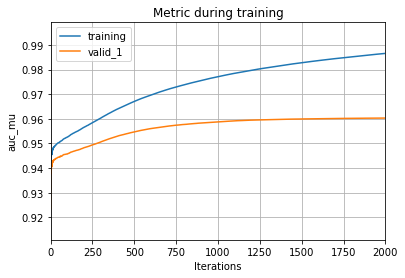

In [48]:
params = {'bagging_fraction': 0.95,
          'bagging_freq': 4,
          'colsample_bytree': 0.5082709715216089,
          'learning_rate': 1e-02, #1e-02
          'max_depth': -1,
          'min_child_samples': 230,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 41,
          'num_leaves': 134,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.5319087827515545,
          'n_estimators' : 2000,
          'objective':'multiclassova',
          'num_class':3,
          'n_jobs' : 8,
          'metric':'auc_mu'} 

# params = {'bagging_fraction': 0.8722222222222222,
#  'bagging_freq': 10,
#  'colsample_bytree': 0.7303258275849434,
#  'learning_rate': 0.001,
#  'max_depth': -1,
#  'min_child_samples': 369,
#  'min_child_weight': 10.0,
#  'min_data_in_leaf': 21,
#  'num_class': 3,
#  'num_leaves': 81,
#  'objective': 'multiclass',
#  'reg_alpha': 0,
#  'reg_lambda': 0,
#  'subsample': 0.9273459710086789,
#  'n_estimators' : 2000,
#  'n_jobs' : 8,
#  'metric':'auc_mu'}


y_data_class = np.argmax(y_data, axis=1)
skf = StratifiedKFold(n_splits=5)#, random_state=1337, shuffle=False)

y_pred_lgbm = dict()

for fold, (train_index, test_index) in enumerate(skf.split(X_tr_train, y_data_class)):
    
    print(train_index.shape)
    print(test_index.shape)
    
    X_train, X_val = X_tr_train.iloc[train_index], X_tr_train.iloc[test_index]
    y_train, y_val = y_data_class[train_index], y_data_class[test_index]

    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)

    # to record eval results for plotting
    evals_result = {}

    # train
    lgb_model = lgb.train(params,
                          lgb_train,
                          num_boost_round=200,
                          valid_sets=[lgb_train, lgb_valid],
                          evals_result=evals_result,
                          verbose_eval=10,
                          early_stopping_rounds=350)
    
#     lgb_model.save_model(f'./boosting/k_fold/lgbm_fold{fold}.txt')
    
    ax = lgb.plot_metric(evals_result, metric='auc_mu')
    plt.show()
    
    y_pred = lgb_model.predict(X_val)
    y_pred_lgbm[f'pred_fold{fold}']  = y_pred
    y_pred_lgbm[f'truth_fold{fold}'] = y_data[test_index]

In [38]:
X_val.shape

(10613, 4)

In [264]:
y_pred = lgb_model.predict(X_val)

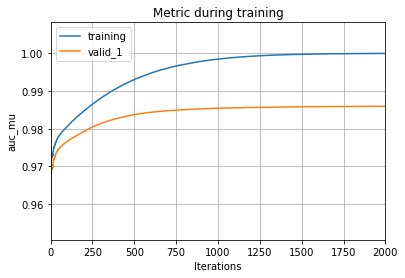

In [37]:
# fig, ax = plt.subplots(1,2,figsize=(12,4))
# ax[0] = lgb.plot_metric(evals_result, metric='multi_logloss')
ax = lgb.plot_metric(evals_result, metric='auc_mu')
plt.show()

In [41]:
# np.save('./5foldcv/lgbm_preds3.npy', y_pred_lgbm, allow_pickle=True)
y_pred_lgbm = np.load('./5foldcv/lgbm_preds3.npy', allow_pickle=True)[()]

In [42]:
# y_pred = lgb_model.predict(X_val)

In [43]:
y_pred_lgbm['pred_fold0']

array([[9.92722432e-01, 1.25282849e-02, 1.29249746e-03],
       [5.59360133e-01, 6.97396029e-02, 1.63686154e-01],
       [9.99654798e-01, 7.88784406e-04, 2.75535836e-04],
       ...,
       [1.17365019e-03, 9.97525928e-01, 1.40672816e-03],
       [3.84873767e-03, 9.65426307e-01, 1.44443712e-02],
       [9.76412074e-02, 8.95095636e-01, 9.22646828e-04]])

In [44]:
# 5.59360133e-01+ 6.97396029e-02+ 1.63686154e-01

0.42000230951294915
0.4275138178658073
0.4352147596897937
0.4315037257744396
0.43170197720747133
0.40978038970034236
0.491119560602347
0.37664382965008003
0.38829135385436425
0.4544471931877137
0.4169824812547717
0.37325125801749215
0.3886257390806114
0.4139256922635554
0.4135364853990894


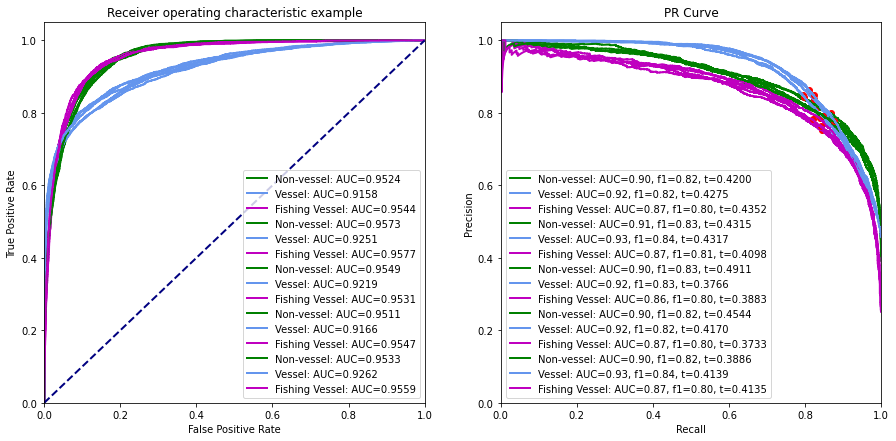

In [49]:
classes = ["Non-vessel", "Vessel", "Fishing Vessel"]
colors=['green','cornflowerblue', 'm']
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)

lw = 2
for f in range(5):
    for c in range(3):

        fpr_val, tpr_val, _ = roc_curve(y_pred_lgbm[f'truth_fold{f}'][:,c], y_pred_lgbm[f'pred_fold{f}'][:,c])
        roc_auc_val = auc(fpr_val, tpr_val)

        plt.plot(fpr_val, tpr_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={roc_auc_val:0.4f}')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(1,2,2)

for f in range(5):
    for c in range(3):
        prec_val, rec_val, pr_thres = precision_recall_curve(y_pred_lgbm[f'truth_fold{f}'][:,c], y_pred_lgbm[f'pred_fold{f}'][:,c])
        pr_auc_val = -1*np.trapz(prec_val, rec_val)

        p1 = np.array(list(zip(prec_val, rec_val)))
        p2 = np.ones_like(p1)
        diff = (p1-p2)
        dist = np.sqrt(diff[:,0]**2+diff[:,1]**2)
        best_thres = np.argmin(dist)
        f1 = 2 * (prec_val[best_thres] * rec_val[best_thres]) / (prec_val[best_thres] + rec_val[best_thres])

        print(pr_thres[best_thres])
        
        plt.plot(rec_val[best_thres], prec_val[best_thres], 'ro')
        plt.plot(rec_val, prec_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={pr_auc_val:0.2f}, f1={f1:0.2f}, t={pr_thres[best_thres]:0.4f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower left")
    
plt.show()

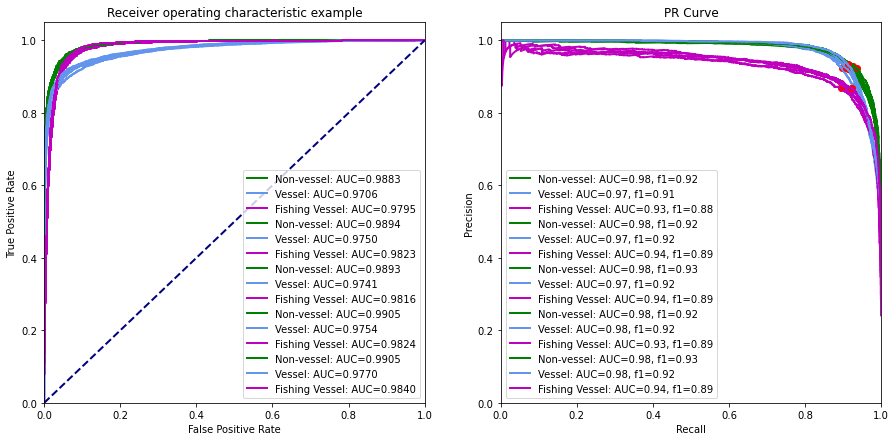

In [80]:
classes = ["Non-vessel", "Vessel", "Fishing Vessel"]
colors=['green','cornflowerblue', 'm']
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)

lw = 2
for f in range(5):
    for c in range(3):

        fpr_val, tpr_val, _ = roc_curve(y_pred_lgbm[f'truth_fold{f}'][:,c], y_pred_lgbm[f'pred_fold{f}'][:,c])
        roc_auc_val = auc(fpr_val, tpr_val)

        plt.plot(fpr_val, tpr_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={roc_auc_val:0.4f}')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(1,2,2)

for f in range(5):
    for c in range(3):
        prec_val, rec_val, _ = precision_recall_curve(y_pred_lgbm[f'truth_fold{f}'][:,c], y_pred_lgbm[f'pred_fold{f}'][:,c])
        pr_auc_val = -1*np.trapz(prec_val, rec_val)

        p1 = np.array(list(zip(prec_val, rec_val)))
        p2 = np.ones_like(p1)
        diff = (p1-p2)
        dist = np.sqrt(diff[:,0]**2+diff[:,1]**2)
        best_thres = np.argmin(dist)
        f1 = 2 * (prec_val[best_thres] * rec_val[best_thres]) / (prec_val[best_thres] + rec_val[best_thres])

        plt.plot(rec_val[best_thres], prec_val[best_thres], 'ro')
        plt.plot(rec_val, prec_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={pr_auc_val:0.2f}, f1={f1:0.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower left")
    
plt.show()

### Meta dataframe

In [81]:
X_tr_meta = pd.DataFrame.copy(X_tr)

In [82]:
all_pred = np.zeros((53067,3))

for fold, (train_index, test_index) in enumerate(skf.split(X_tr, y_data_class)):
    
    val_preds = y_pred_lgbm[f'pred_fold{fold}'] 
    all_pred[test_index] = val_preds

In [83]:
X_tr_meta['pred_lgbm_0'] = all_pred[:,0]
X_tr_meta['pred_lgbm_1'] = all_pred[:,1]
X_tr_meta['pred_lgbm_2'] = all_pred[:,2]

In [84]:
X_tr_meta

,max_vv,min_vv,std_vv,mean_vv,median_vv,max_vh,min_vh,std_vh,mean_vh,median_vh,...,vh_perimeter,vh_perimeter_crofton,vh_solidity,bathymetry,owiWindDirection,owiWindQuality,owiWindSpeed,pred_lgbm_0,pred_lgbm_1,pred_lgbm_2
0,47.375000,14.750000,2.715456,25.455446,25.437500,36.937500,12.15625,2.041302,19.603176,19.453125,...,37.591883,38.517207,0.834951,-3.171875,225.2500,3.0,3.818359,0.996820,0.002915,0.000265
1,50.077393,15.687500,3.072076,24.639688,24.281250,34.687500,12.31250,1.584069,22.081829,22.265625,...,19.899495,21.547421,0.945946,-24.031250,221.7500,3.0,1.943359,0.745595,0.176990,0.077415
2,49.106445,25.468750,2.325520,34.088936,33.968750,43.437500,9.71875,3.210182,21.004517,20.515625,...,90.491378,94.980166,0.661417,-8.078125,255.2500,0.0,8.421875,0.999758,0.000185,0.000057
3,37.257812,11.687500,2.234648,25.005165,25.078125,33.375000,7.90625,1.828051,19.352524,19.359375,...,40.727922,41.294008,0.828283,-10.140625,270.7500,3.0,2.445312,0.948360,0.031021,0.020618
4,44.636719,27.703125,2.060109,34.722076,34.648438,41.804688,26.84375,1.424176,31.282898,31.140625,...,75.077164,76.344300,0.691429,-16.390625,307.0000,0.0,11.609375,0.805824,0.079351,0.114826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53062,58.476562,26.843750,2.752373,34.112717,33.839844,41.671875,10.84375,3.717664,20.608065,19.828125,...,103.597980,100.898561,0.785933,-2576.000000,218.0000,2.0,9.632812,0.003593,0.992551,0.003856
53063,59.937500,24.968750,2.849114,32.816883,32.609375,47.466797,14.81250,2.569103,21.761190,21.625000,...,45.177670,46.657043,0.812030,-36.718750,91.9375,2.0,7.687500,0.005498,0.982174,0.012328
53064,56.078125,22.390625,3.448292,31.855562,31.453125,49.141113,15.09375,3.540825,23.873657,23.343750,...,93.426407,94.329521,0.722714,-3970.000000,352.0000,3.0,5.378906,0.000075,0.999663,0.000262
53065,53.187500,14.250000,2.940977,27.503479,27.296875,38.187500,10.09375,2.330252,17.614729,17.531250,...,55.455844,55.256954,0.851064,-1330.000000,224.1250,3.0,4.296875,0.019473,0.976805,0.003722


### Proximity derived predictions

In [112]:
X_id_r_c = pd.read_csv('./id_r_c.csv').iloc[:,1:]
X_id_r_c.head()

,img_id,det_row,det_col
0,a7aafac0bb5d311ft,14689.0,3583.0
1,7990e9589b9ff3bft,14086.0,17772.0
2,eba22dd5e0378888t,18258.0,22518.0
3,a4ca2e205513eb08t,15170.0,2970.0
4,a08d07f4f8522f12t,16378.0,22917.0


In [107]:
img_ids = X_id_r_c.img_id.unique()

In [245]:
X_tr_prox = pd.DataFrame(index=range(all_files), dtype=np.float64)
radius = 200
count = 0

pbar = Progbar(img_ids.shape[0])

for i, id in enumerate(img_ids):
    
    id_args = np.argwhere(X_id_r_c['img_id'].values == id)[:,0]
    
    subset = X_id_r_c.iloc[id_args]
    points = list(zip(subset.det_row.values, subset.det_col.values))

    #get all distances
    distances = [calculate_distance(points) for points in itertools.product(points, repeat=2)]

    #get local preds
    local_preds = X_tr_meta.iloc[id_args].iloc[:,-3:].values
    
    #local truth
    local_truth = y_data[id_args]
    
    for d in range(len(points)):
    
        dists = np.array(distances)[d*len(points):(d+1)*len(points)]
        
        #get orig plus top 5
        idx_near = np.argwhere(dists<radius)[:6,]
        
        #initalize at all zeros in case there are not 5 proximate detections
        local_preds_sliced = np.zeros((6,3))
        local_preds_sliced[:idx_near.shape[0],:] = local_preds[idx_near[:,0]]
    
        #add to df
        X_tr_prox.loc[count, f'orig_pred_0'] = local_preds_sliced[0][0]
        X_tr_prox.loc[count, f'orig_pred_1'] = local_preds_sliced[0][1]
        X_tr_prox.loc[count, f'orig_pred_2'] = local_preds_sliced[0][2]

        for p in range(1,6):

            X_tr_prox.loc[count, f'near_pred_{p-1}_0'] = local_preds_sliced[p][0]
            X_tr_prox.loc[count, f'near_pred_{p-1}_1'] = local_preds_sliced[p][1]
            X_tr_prox.loc[count, f'near_pred_{p-1}_2'] = local_preds_sliced[p][2]
            
        X_tr_prox.loc[count, f'gt_0'] = local_truth[d,0]
        X_tr_prox.loc[count, f'gt_1'] = local_truth[d,1]
        X_tr_prox.loc[count, f'gt_2'] = local_truth[d,2]
            
        count+=1

    pbar.add(1)    

554/554 [==============================] - 470s 848ms/step


In [249]:
X_tr_prox.shape

(53067, 21)

In [263]:
# X_tr_prox.to_csv('X_tr_prox.csv')

In [ ]:
X_tr_new = pd.concat(
    [
        X_tr.reset_index(drop=True),
        x_meta_features.reset_index(drop=True),
    ],
    axis=1,
    ignore_index=False,
)

In [135]:
import itertools

In [214]:
def calculate_distance(points):
    [[x1, y1], [x2, y2]] = points
    return sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

inputlist = [[1,2],[2,3],[3,4],[4,5],[5,6]]
distances = [calculate_distance(points) for points in itertools.product(inputlist, repeat=2)] #combinations(inputlist, 2)]

(42453,)
(10614,)
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 42453, number of used features: 18
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: 

/root/miniconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

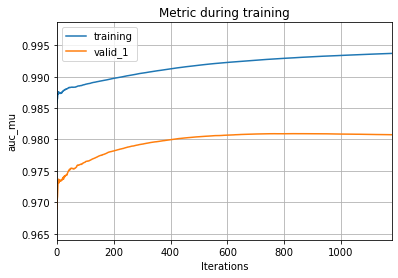

(42453,)
(10614,)
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 42453, number of used features: 18
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: 

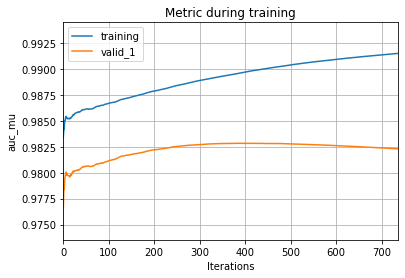

(42454,)
(10613,)
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 42454, number of used features: 18
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: 

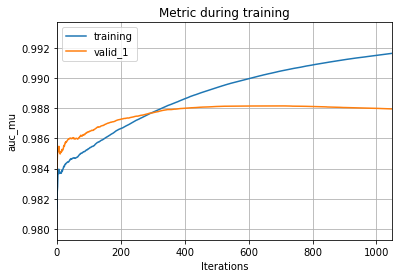

(42454,)
(10613,)
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 42454, number of used features: 18
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: 

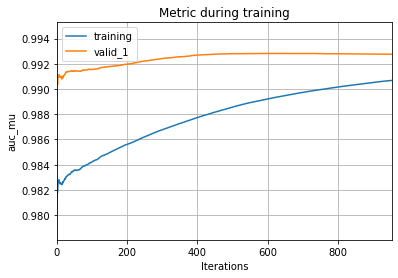

(42454,)
(10613,)
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4590
[LightGBM] [Info] Number of data points in the train set: 42454, number of used features: 18
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: 

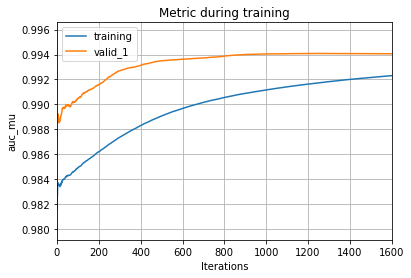

In [259]:
y_data_class = np.argmax(X_tr_prox.iloc[:,-3:].values, axis=1)
skf = StratifiedKFold(n_splits=5)#, random_state=1337, shuffle=False)

y_pred_lgbm = dict()

for fold, (train_index, test_index) in enumerate(skf.split(X_tr_prox.iloc[:,:-3], y_data_class)):
    
    print(train_index.shape)
    print(test_index.shape)
    
    X_train, X_val = X_tr_prox.iloc[:,:-3].iloc[train_index], X_tr_prox.iloc[:,:-3].iloc[test_index]
    y_train, y_val = y_data_class[train_index], y_data_class[test_index]

    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_val, y_val, reference=lgb_train)

    # to record eval results for plotting
    evals_result = {}

    # train
    lgb_model = lgb.train(params,
                          lgb_train,
                          num_boost_round=200,
                          valid_sets=[lgb_train, lgb_valid],
                          evals_result=evals_result,
                          verbose_eval=10,
                          early_stopping_rounds=350)
    
    ax = lgb.plot_metric(evals_result, metric='auc_mu')
    plt.show()
    
    y_pred = lgb_model.predict(X_val)
    y_pred_lgbm[f'pred_fold{fold}']  = y_pred
    y_pred_lgbm[f'truth_fold{fold}'] = X_tr_prox.iloc[:,-3:].values[test_index]

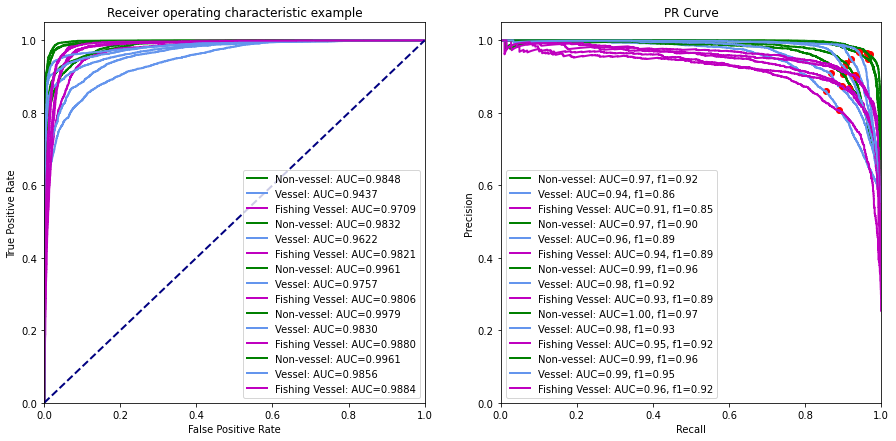

In [260]:
classes = ["Non-vessel", "Vessel", "Fishing Vessel"]
colors=['green','cornflowerblue', 'm']
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)

lw = 2
for f in range(5):
    for c in range(3):

        fpr_val, tpr_val, _ = roc_curve(y_pred_lgbm[f'truth_fold{f}'][:,c], y_pred_lgbm[f'pred_fold{f}'][:,c])
        roc_auc_val = auc(fpr_val, tpr_val)

        plt.plot(fpr_val, tpr_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={roc_auc_val:0.4f}')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(1,2,2)

for f in range(5):
    for c in range(3):
        prec_val, rec_val, _ = precision_recall_curve(y_pred_lgbm[f'truth_fold{f}'][:,c], y_pred_lgbm[f'pred_fold{f}'][:,c])
        pr_auc_val = -1*np.trapz(prec_val, rec_val)

        p1 = np.array(list(zip(prec_val, rec_val)))
        p2 = np.ones_like(p1)
        diff = (p1-p2)
        dist = np.sqrt(diff[:,0]**2+diff[:,1]**2)
        best_thres = np.argmin(dist)
        f1 = 2 * (prec_val[best_thres] * rec_val[best_thres]) / (prec_val[best_thres] + rec_val[best_thres])

        plt.plot(rec_val[best_thres], prec_val[best_thres], 'ro')
        plt.plot(rec_val, prec_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={pr_auc_val:0.2f}, f1={f1:0.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower left")
    
plt.show()

### Feature Importance

In [41]:
feature_importance = pd.DataFrame()
fold_importance = pd.DataFrame()
# fold_importance["feature"] = X_tr.columns
fold_importance["feature"] = x_meta_features.columns
fold_importance["importance"] = lgb_model.feature_importance()
feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

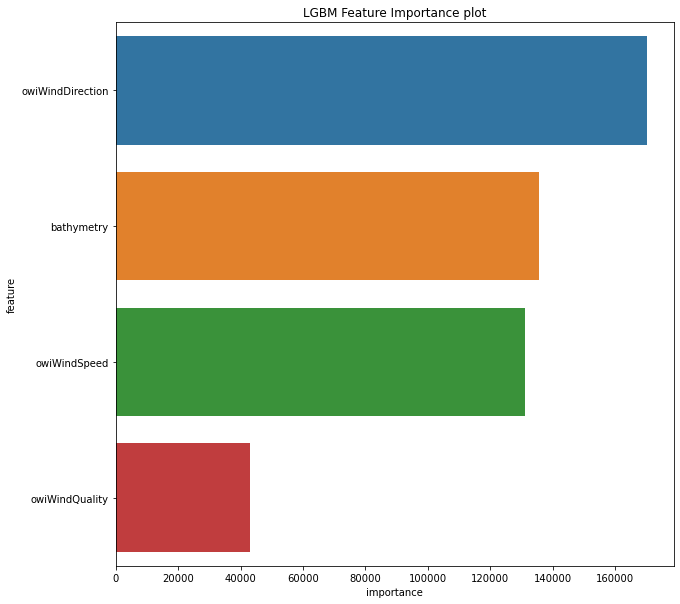

In [43]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:100].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(10, 10));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGBM Feature Importance plot');

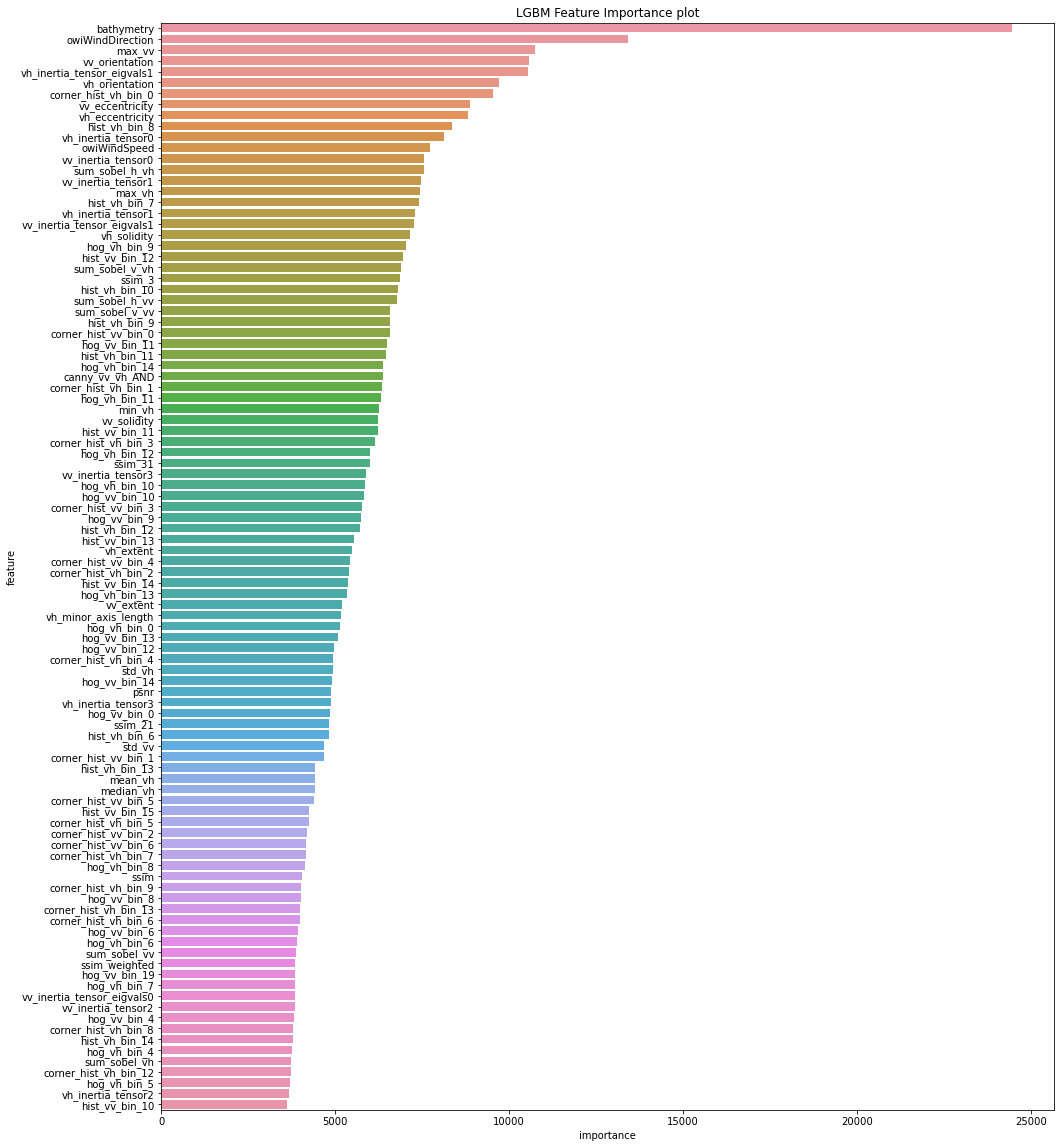

In [53]:
cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:100].index

best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

plt.figure(figsize=(16, 20));
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
plt.title('LGBM Feature Importance plot');

# XGBoost development

#### Random search for optimal hyperparameters

In [31]:
#random search for hyperparameter optimization
param_test ={'num_leaves': sp_randint(15, 150), 
             'min_child_samples': sp_randint(100, 500), 
             'min_data_in_leaf': sp_randint(20,150), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
             'learning_rate': [0.1, 0.01],
             'bagging_freq': [3, 4, 5, 6, 7],
             'bagging_fraction': np.linspace(0.6, 0.95, 10),
             'max_depth': [6, 10, 15, 20]}

fit_params={"early_stopping_rounds": 30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_val, y_val_class)],
            'verbose': 100}

n_HP_points_to_test = 250

clf = xgb.XGBClassifier(learning_rate=0.01,
                        n_estimators=5000,
                        objective= 'binary:logistic',
                        nthread=8,
                        eval_metric='auc',
                        seed=7)

gs_xgb = RandomizedSearchCV(estimator=clf, 
                            param_distributions=param_test, 
                            n_iter=n_HP_points_to_test,
                            scoring='roc_auc',
                            cv=3,
                            refit=True,
                            random_state=7,
                            verbose=True)

In [ ]:
gs_xgb.fit(x_train, y_train[:,0], **fit_params)
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

#### Train model with optimal parameters

In [27]:
params = {'bagging_fraction': 0.95,
          'bagging_freq': 4,
          'colsample_bytree': 0.5082709715216089,
          'learning_rate': 1e-02,
          'max_depth': 15,
          'min_child_samples': 230,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 41,
          'num_leaves': 134,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.5319087827515545,
          'num_class':3} 

xgb_model = xgb.XGBClassifier(**params,
                              n_estimators=750,
                              objective='multi:softprob', #'binary:logistic',
                              nthread=8,
                              eval_metric='mlogloss',
                              seed=7)

In [146]:
test_index

array([13354, 13355, 13356, ..., 53064, 53065, 53066])

In [28]:
y_data_class = np.argmax(y_data, axis=1)
skf = StratifiedKFold(n_splits=5)#, random_state=1337)

y_pred_xgbm = dict()

for fold, (train_index, test_index) in enumerate(skf.split(X_tr, y_data_class)):
    
    print(train_index.shape)
    print(test_index.shape)
    
    X_train, X_val = X_tr.iloc[train_index], X_tr.iloc[test_index]
    y_train, y_val = y_data_class[train_index], y_data_class[test_index]

    # train
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train),(X_val, y_val)],
                  verbose=True,
                  early_stopping_rounds=400)
    
    y_pred = xgb_model.predict_proba(X_val)
    y_pred_xgbm[f'pred_fold{fold}']  = y_pred
    y_pred_xgbm[f'truth_fold{fold}'] = y_data[test_index]

(42453,)
(10614,)


/root/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:16:15] WARNING: ../src/learner.cc:541: 
Parameters: { bagging_fraction, bagging_freq, min_child_samples, min_data_in_leaf, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-mlogloss:1.08950	validation_1-mlogloss:1.09050
[1]	validation_0-mlogloss:1.08032	validation_1-mlogloss:1.08228
[2]	validation_0-mlogloss:1.07146	validation_1-mlogloss:1.07441
[3]	validation_0-mlogloss:1.06258	validation_1-mlogloss:1.06647
[4]	validation_0-mlogloss:1.05399	validation_1-mlogloss:1.05874
[5]	validation_0-mlogloss:1.04537	validation_1-mlogloss:1.05103
[6]	validation_0-mlogloss:1.03677	validation_1-mlogloss:1.04332
[7]	validation_0-mlogloss:1.02859	validation_1-mlogloss:1.03600
[8]	validation_0-mlogloss:1.02043	validation_1-mlogloss:1.02871
[9]	validation_0-mlogloss

In [29]:
test_index

array([13354, 13355, 13356, ..., 53064, 53065, 53066])

In [33]:
# np.save('./5foldcv/xgboost_preds.npy', y_pred_xgbm, allow_pickle=True)

In [40]:
all_pred = np.zeros((53067,3))

for fold, (train_index, test_index) in enumerate(skf.split(X_tr, y_data_class)):
    
    val_preds = y_pred_xgbm[f'pred_fold{fold}'] 
    all_pred[test_index] = val_preds

In [41]:
X_tr_meta['pred_xgbm_0'] = all_pred[:,0]
X_tr_meta['pred_xgbm_1'] = all_pred[:,1]
X_tr_meta['pred_xgbm_2'] = all_pred[:,2]

In [42]:
X_tr_meta.head()

,max_vv,min_vv,std_vv,mean_vv,median_vv,max_vh,min_vh,std_vh,mean_vh,median_vh,...,vh_orientation,vh_perimeter,vh_perimeter_crofton,vh_solidity,pred_lgbm_0,pred_lgbm_1,pred_lgbm_2,pred_xgbm_0,pred_xgbm_1,pred_xgbm_2
0,47.375000,14.750000,2.715456,25.455446,25.437500,36.937500,12.15625,2.041302,19.603176,19.453125,...,-0.254476,37.591883,38.517207,0.834951,0.987314,0.008094,0.004591,0.945878,0.034110,0.020013
1,50.077393,15.687500,3.072076,24.639688,24.281250,34.687500,12.31250,1.584069,22.081829,22.265625,...,1.482894,19.899495,21.547421,0.945946,0.510538,0.142104,0.347359,0.397026,0.194788,0.408186
2,49.106445,25.468750,2.325520,34.088936,33.968750,43.437500,9.71875,3.210182,21.004517,20.515625,...,0.140653,90.491378,94.980166,0.661417,0.999201,0.000608,0.000191,0.992242,0.005099,0.002660
3,37.257812,11.687500,2.234648,25.005165,25.078125,33.375000,7.90625,1.828051,19.352524,19.359375,...,-0.170180,40.727922,41.294008,0.828283,0.969151,0.025340,0.005510,0.919484,0.055291,0.025225
4,44.636719,27.703125,2.060109,34.722076,34.648438,41.804688,26.84375,1.424176,31.282898,31.140625,...,0.135825,75.077164,76.344300,0.691429,0.630951,0.130975,0.238074,0.523653,0.208611,0.267735


In [152]:
results = xgb_model.evals_result()

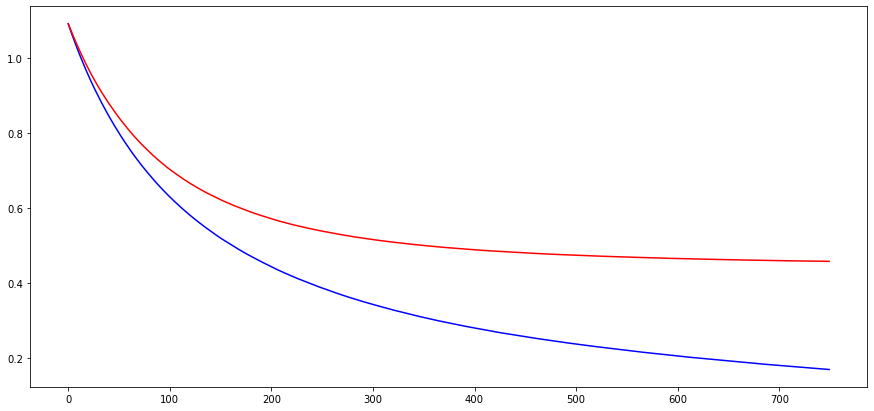

In [153]:
plt.figure(figsize=(15,7))
plt.plot(results['validation_0']['mlogloss'], 'b', label='training set auc')
plt.plot(results['validation_1']['mlogloss'], 'r', label='val set auc')
plt.show()

In [155]:
y_pred_xgb = xgb_model.predict_proba(X_val)

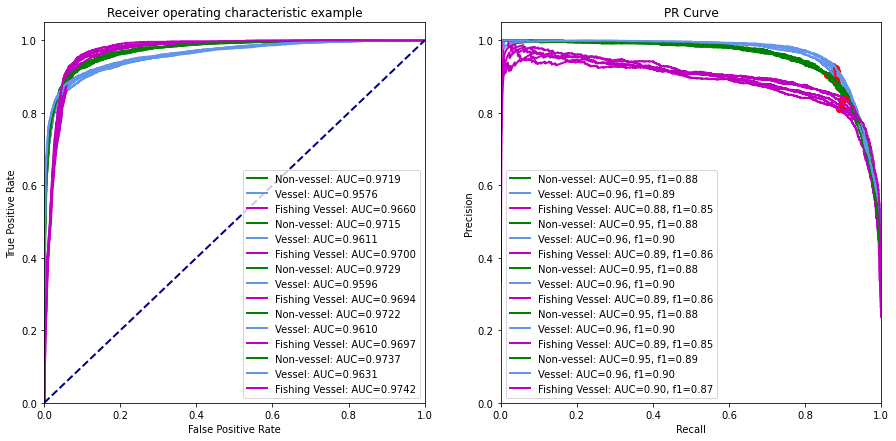

In [31]:
classes = ["Non-vessel", "Vessel", "Fishing Vessel"]
colors=['green','cornflowerblue', 'm']
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)

lw = 2
for f in range(5):
    for c in range(3):

        fpr_val, tpr_val, _ = roc_curve(y_pred_xgbm[f'truth_fold{f}'][:,c], y_pred_xgbm[f'pred_fold{f}'][:,c])
        roc_auc_val = auc(fpr_val, tpr_val)

        plt.plot(fpr_val, tpr_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={roc_auc_val:0.4f}')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(1,2,2)

for f in range(5):
    for c in range(3):
        prec_val, rec_val, _ = precision_recall_curve(y_pred_xgbm[f'truth_fold{f}'][:,c], y_pred_xgbm[f'pred_fold{f}'][:,c])
        pr_auc_val = -1*np.trapz(prec_val, rec_val)

        p1 = np.array(list(zip(prec_val, rec_val)))
        p2 = np.ones_like(p1)
        diff = (p1-p2)
        dist = np.sqrt(diff[:,0]**2+diff[:,1]**2)
        best_thres = np.argmin(dist)
        f1 = 2 * (prec_val[best_thres] * rec_val[best_thres]) / (prec_val[best_thres] + rec_val[best_thres])

        plt.plot(rec_val[best_thres], prec_val[best_thres], 'ro')
        plt.plot(rec_val, prec_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={pr_auc_val:0.2f}, f1={f1:0.2f}')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower left")
    
plt.show()

### CatBoost model 

In [163]:
cat_model = CatBoostClassifier(iterations=750,
                               learning_rate=1e-02,
                               l2_leaf_reg=3.5,
                               depth=8,
                               rsm=0.98,
                               loss_function= 'MultiClass',
                               eval_metric='AUC',
                               use_best_model=True,
                               random_seed=7)

In [164]:
cat_model.fit(X_train, y_train_class,
              eval_set=(X_val, y_val_class),
              verbose=True,
              early_stopping_rounds=400)

0:	test: 0.8819417	best: 0.8819417 (0)	total: 81.3ms	remaining: 1m
1:	test: 0.8911886	best: 0.8911886 (1)	total: 160ms	remaining: 59.7s
2:	test: 0.8998467	best: 0.8998467 (2)	total: 235ms	remaining: 58.6s
3:	test: 0.9023639	best: 0.9023639 (3)	total: 316ms	remaining: 58.9s
4:	test: 0.9053489	best: 0.9053489 (4)	total: 387ms	remaining: 57.7s
5:	test: 0.9049217	best: 0.9053489 (4)	total: 454ms	remaining: 56.3s
6:	test: 0.9051539	best: 0.9053489 (4)	total: 525ms	remaining: 55.7s
7:	test: 0.9056887	best: 0.9056887 (7)	total: 604ms	remaining: 56s
8:	test: 0.9068437	best: 0.9068437 (8)	total: 677ms	remaining: 55.7s
9:	test: 0.9072295	best: 0.9072295 (9)	total: 748ms	remaining: 55.4s
10:	test: 0.9072364	best: 0.9072364 (10)	total: 815ms	remaining: 54.8s
11:	test: 0.9077451	best: 0.9077451 (11)	total: 882ms	remaining: 54.2s
12:	test: 0.9076609	best: 0.9077451 (11)	total: 947ms	remaining: 53.7s
13:	test: 0.9080254	best: 0.9080254 (13)	total: 1.02s	remaining: 53.4s
14:	test: 0.9084800	best: 0.90

In [165]:
y_pred_cat = cat_model.predict_proba(X_val)

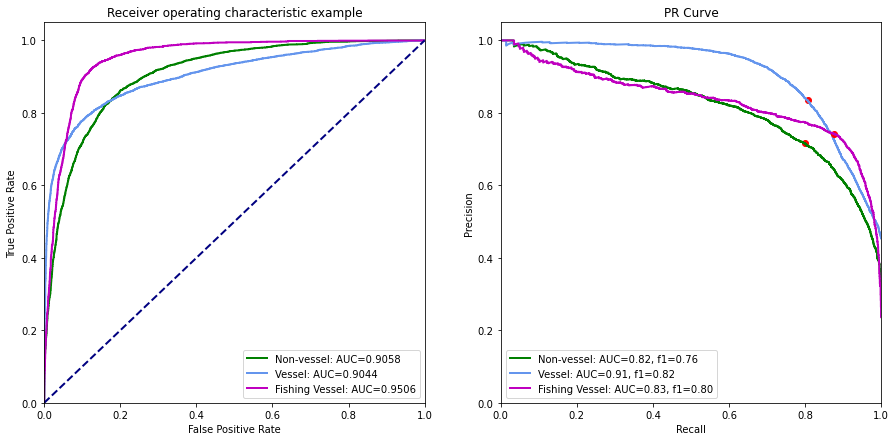

In [166]:
classes = ["Non-vessel", "Vessel", "Fishing Vessel"]
colors=['green','cornflowerblue', 'm']
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)

lw = 2
    
for c in range(3):
    fpr_val, tpr_val, _ = roc_curve(y_val[:,c], y_pred_cat[:,c])
    roc_auc_val = auc(fpr_val, tpr_val)

    plt.plot(fpr_val, tpr_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={roc_auc_val:0.4f}')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(1,2,2)
for c in range(3):
    prec_val, rec_val, _ = precision_recall_curve(y_val[:,c], y_pred_cat[:,c])
    pr_auc_val = -1*np.trapz(prec_val, rec_val)
    
    p1 = np.array(list(zip(prec_val, rec_val)))
    p2 = np.ones_like(p1)
    diff = (p1-p2)
    dist = np.sqrt(diff[:,0]**2+diff[:,1]**2)
    best_thres = np.argmin(dist)
    f1 = 2 * (prec_val[best_thres] * rec_val[best_thres]) / (prec_val[best_thres] + rec_val[best_thres])
    
    plt.plot(rec_val[best_thres], prec_val[best_thres], 'ro')
    plt.plot(rec_val, prec_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={pr_auc_val:0.2f}, f1={f1:0.2f}')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower left")
    
plt.show()

In [167]:
y_pred_cat.shape

(10614, 3)

In [175]:
ensem = np.concatenate((np.expand_dims(y_pred, axis=0),
                        np.expand_dims(y_pred_xgb, axis=0)),
#                         np.expand_dims(y_pred_cat, axis=0)),
                       axis=0)
y_pred_ensem = np.mean(ensem, axis=0)

In [176]:
y_pred_ensem.shape

(10614, 3)

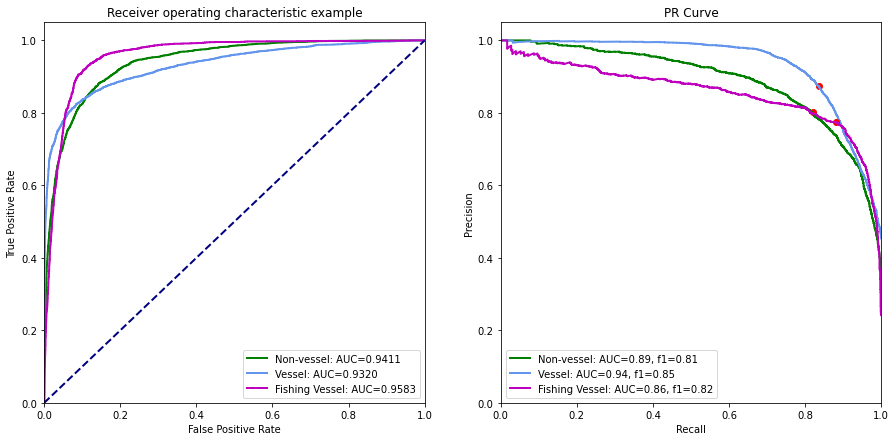

In [177]:
classes = ["Non-vessel", "Vessel", "Fishing Vessel"]
colors=['green','cornflowerblue', 'm']
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)

lw = 2
    
for c in range(3):
    fpr_val, tpr_val, _ = roc_curve(y_val[:,c], y_pred_ensem[:,c])
    roc_auc_val = auc(fpr_val, tpr_val)

    plt.plot(fpr_val, tpr_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={roc_auc_val:0.4f}')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

plt.subplot(1,2,2)
for c in range(3):
    prec_val, rec_val, _ = precision_recall_curve(y_val[:,c], y_pred_ensem[:,c])
    pr_auc_val = -1*np.trapz(prec_val, rec_val)
    
    p1 = np.array(list(zip(prec_val, rec_val)))
    p2 = np.ones_like(p1)
    diff = (p1-p2)
    dist = np.sqrt(diff[:,0]**2+diff[:,1]**2)
    best_thres = np.argmin(dist)
    f1 = 2 * (prec_val[best_thres] * rec_val[best_thres]) / (prec_val[best_thres] + rec_val[best_thres])
    
    plt.plot(rec_val[best_thres], prec_val[best_thres], 'ro')
    plt.plot(rec_val, prec_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={pr_auc_val:0.2f}, f1={f1:0.2f}')
    
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.legend(loc="lower left")
    
plt.show()

# OOF Meta Model

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(X_tr_meta, y_data, test_size=0.20, random_state=42)

In [46]:
y_train_class = np.argmax(y_train_meta, axis=1)
y_val_class = np.argmax(y_val_meta, axis=1)

In [48]:
meta_model = LogisticRegression(solver='liblinear',
                               max_iter=100,
                                multi_class='auto',
                                verbose=True,
                                warm_start=False,
                                n_jobs=8,
                                l1_ratio=None)

In [49]:
meta_model.fit(X_train_meta, y_train_class)

/root/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1357: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]

/root/miniconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(n_jobs=8, solver='liblinear', verbose=True)

In [52]:
y_pred_meta = meta_model.predict_proba(X_val_meta)

In [53]:
y_pred_meta

array([[1.31529275e-01, 2.26817197e-01, 6.41653528e-01],
       [7.42420690e-02, 1.60639395e-01, 7.65118536e-01],
       [2.18275463e-02, 1.30363189e-01, 8.47809265e-01],
       ...,
       [1.49133608e-03, 9.98314374e-01, 1.94289667e-04],
       [7.16577071e-01, 2.38014371e-01, 4.54085574e-02],
       [1.06375204e-02, 9.88857372e-01, 5.05107368e-04]])

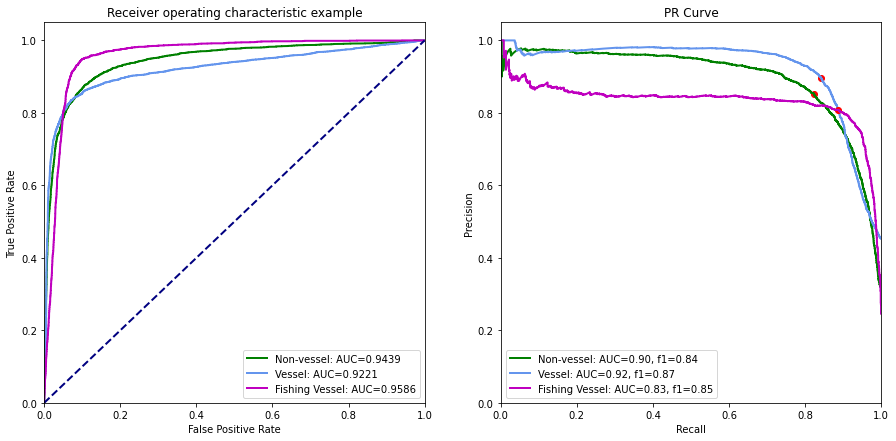

In [56]:
multi_class_curves(y_val_meta, y_pred_meta)

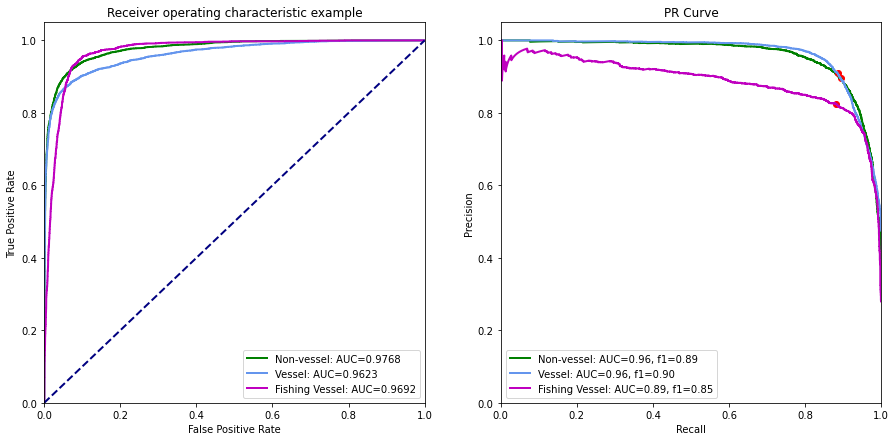

In [63]:
multi_class_curves(y_val_meta, X_tr_meta[['pred_lgbm_0','pred_lgbm_1','pred_lgbm_2']].values[X_val_meta.index.values])

In [55]:
def multi_class_curves(gt, preds):
    classes = ["Non-vessel", "Vessel", "Fishing Vessel"]
    colors=['green','cornflowerblue', 'm']
    plt.figure(figsize=(15,7))
    plt.subplot(1,2,1)

    lw = 2

    for c in range(3):
        fpr_val, tpr_val, _ = roc_curve(gt[:,c], preds[:,c])
        roc_auc_val = auc(fpr_val, tpr_val)

        plt.plot(fpr_val, tpr_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={roc_auc_val:0.4f}')

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    for c in range(3):
        prec_val, rec_val, _ = precision_recall_curve(gt[:,c], preds[:,c])
        pr_auc_val = -1*np.trapz(prec_val, rec_val)

        p1 = np.array(list(zip(prec_val, rec_val)))
        p2 = np.ones_like(p1)
        diff = (p1-p2)
        dist = np.sqrt(diff[:,0]**2+diff[:,1]**2)
        best_thres = np.argmin(dist)
        f1 = 2 * (prec_val[best_thres] * rec_val[best_thres]) / (prec_val[best_thres] + rec_val[best_thres])

        plt.plot(rec_val[best_thres], prec_val[best_thres], 'ro')
        plt.plot(rec_val, prec_val, color=colors[c], lw=lw, label=f'{classes[c]}: AUC={pr_auc_val:0.2f}, f1={f1:0.2f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR Curve')
    plt.legend(loc="lower left")

    plt.show()

# Holdout testset eval

In [269]:
test_files = sorted(glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/*'))
test_npy_files = glob.glob('/tf/media/ryan/bigboi/datasets/xview3/val/npy_all/*')

In [270]:
test_files

['/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_00.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_01.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_02.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_03.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_04.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_05.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_06.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_07.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_08.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_09.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_10.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecords_all/val_shard_11.tfrec',
 '/tf/media/ryan/bigboi/datasets/xview3/val/tfrecord

In [271]:
len(test_npy_files)

19224

In [331]:
test_gen = create_datagen(test_files,
                           shuffle=False,
                           repeat=True,
                           batch_size=1,
                           aug=False,
                           progressive_training=False)

In [298]:
len(test_npy_files)

19224

In [329]:
X_test = pd.DataFrame(index=range(len(test_npy_files)), dtype=np.float64)
# y_test = np.zeros((len(test_npy_files), 3))

In [300]:
pbar = Progbar(len(test_npy_files))

for j, (x, y) in enumerate(test_gen):
    
    x_vv = x.numpy()[0,:,:,0]
    x_vh = x.numpy()[0,:,:,1]
    x_cc = x.numpy()[0,:,:,2]
    
    X_test.loc[j, f'max_vv'] = np.amax(x_vv)
    X_test.loc[j, f'min_vv'] = np.amin(x_vv)
    X_test.loc[j, f'std_vv'] = np.std(x_vv)
    X_test.loc[j, f'mean_vv'] = np.mean(x_vv)
    X_test.loc[j, f'median_vv'] = np.median(x_vv)
    
    X_test.loc[j, f'max_vh'] = np.amax(x_vh)
    X_test.loc[j, f'min_vh'] = np.amin(x_vh)
    X_test.loc[j, f'std_vh'] = np.std(x_vh)
    X_test.loc[j, f'mean_vh'] = np.mean(x_vh)
    X_test.loc[j, f'median_vh'] = np.median(x_vh)
    
    X_test.loc[j, f'ssim'] = ssim(x_vv, x_vh, data_range=100.0)
    X_test.loc[j, f'ssim_weighted'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=True)
    X_test.loc[j, f'ssim_3'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=3)
    X_test.loc[j, f'ssim_7'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=7)
    X_test.loc[j, f'ssim_21'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=21)
    X_test.loc[j, f'ssim_31'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=31)
    X_test.loc[j, f'psnr'] = peak_signal_noise_ratio(x_vv, x_vh, data_range=100.0)
    
    #edges
    X_test.loc[j, f'sum_sobel_vv'] = np.sum(sobel(x_vv))
    X_test.loc[j, f'sum_sobel_vh'] = np.sum(sobel(x_vh))
    X_test.loc[j, f'sum_sobel_v_vv'] = np.sum(sobel_v(x_vv))
    X_test.loc[j, f'sum_sobel_v_vh'] = np.sum(sobel_v(x_vh))
    X_test.loc[j, f'sum_sobel_h_vv'] = np.sum(sobel_h(x_vv))
    X_test.loc[j, f'sum_sobel_h_vh'] = np.sum(sobel_h(x_vh))
    
    
    #simple histogram
    hist = np.histogram(x_vv, bins=20, range=(0,50))[0]
    for h in range(hist.shape[0]):
        X_test.loc[j, f'hist_vv_bin_{h}'] = hist[h]
    
    hist = np.histogram(x_vh, bins=20, range=(0,50))[0]
    for h in range(hist.shape[0]):
        X_test.loc[j, f'hist_vh_bin_{h}'] = hist[h]
    
    #HOG
    hog_image = hog(x_vv, orientations=8, pixels_per_cell=(2,2),
                    cells_per_block=(1, 1), visualize=False)
        
    hog_ = np.histogram(hog_image, bins=20, range=(0,1))[0]
    for h in range(hog_.shape[0]):
        X_test.loc[j, f'hog_vv_bin_{h}'] = hog_[h]
        
    hog_image = hog(x_vh, orientations=8, pixels_per_cell=(2,2),
                    cells_per_block=(1, 1), visualize=False)
    hog_ = np.histogram(hog_image, bins=20, range=(0,1))[0]
    for h in range(hog_.shape[0]):
        X_test.loc[j, f'hog_vh_bin_{h}'] = hog_[h]


    #canny
    can_vh = canny(x_vh)
    can_vv = canny(x_vv)
    X_test.loc[j, f'canny_vv_vh_AND'] = np.sum(np.logical_and(can_vv, can_vh))/(64*64)
    
    #corners
    corner_vv = corner_fast(x_vv)
    hist = np.histogram(corner_vv, bins=20, range=(0,200))[0]
    for h in range(hist.shape[0]):
        X_test.loc[j, f'corner_hist_vv_bin_{h}'] = hist[h]
        
    corner_vh = corner_fast(x_vh)
    hist = np.histogram(corner_vh, bins=20, range=(0,200))[0]
    for h in range(hist.shape[0]):
        X_test.loc[j, f'corner_hist_vh_bin_{h}'] = hist[h]
    
    #region based
    mask = x_vv > threshold_yen(x_vv)
    label_img = label(mask)
    areas = [region.area for region in regionprops(label_img)]
    max_area = np.amax(areas)
    
    for region in regionprops(label_img):
        if region.area == max_area:
            X_test.loc[j, f'vv_area'] = region.area
            X_test.loc[j, f'vv_bbox_area'] = region.bbox_area
            X_test.loc[j, f'vv_convex_area'] = region.convex_area
            X_test.loc[j, f'vv_eccentricity'] = region.eccentricity
            X_test.loc[j, f'vv_equivalent_diameter'] = region.equivalent_diameter
            X_test.loc[j, f'vv_euler_number'] = region.euler_number
            X_test.loc[j, f'vv_extent'] = region.extent
            X_test.loc[j, f'vv_feret_diameter_max'] = region.feret_diameter_max
            X_test.loc[j, f'vv_filled_area'] = region.filled_area
            X_test.loc[j, f'vv_inertia_tensor0'] = region.inertia_tensor.ravel()[0]
            X_test.loc[j, f'vv_inertia_tensor1'] = region.inertia_tensor.ravel()[1]
            X_test.loc[j, f'vv_inertia_tensor2'] = region.inertia_tensor.ravel()[2]
            X_test.loc[j, f'vv_inertia_tensor3'] = region.inertia_tensor.ravel()[3]
            X_test.loc[j, f'vv_inertia_tensor_eigvals0'] = region.inertia_tensor_eigvals[0]
            X_test.loc[j, f'vv_inertia_tensor_eigvals1'] = region.inertia_tensor_eigvals[1]
            X_test.loc[j, f'vv_major_axis_length'] = region.major_axis_length
            X_test.loc[j, f'vv_minor_axis_length'] = region.minor_axis_length
            X_test.loc[j, f'vv_orientation'] = region.orientation
            X_test.loc[j, f'vv_perimeter'] = region.perimeter
            X_test.loc[j, f'vv_perimeter_crofton'] = region.perimeter_crofton
            X_test.loc[j, f'vv_solidity'] = region.solidity
            
    mask = x_vh > threshold_yen(x_vh)
    label_img = label(mask)
    areas = [region.area for region in regionprops(label_img)]
    max_area = np.amax(areas)
    
    for region in regionprops(label_img):
        if region.area == max_area:
            X_test.loc[j, f'vh_area'] = region.area
            X_test.loc[j, f'vh_bbox_area'] = region.bbox_area
            X_test.loc[j, f'vh_convex_area'] = region.convex_area
            X_test.loc[j, f'vh_eccentricity'] = region.eccentricity
            X_test.loc[j, f'vh_equivalent_diameter'] = region.equivalent_diameter
            X_test.loc[j, f'vh_euler_number'] = region.euler_number
            X_test.loc[j, f'vh_extent'] = region.extent
            X_test.loc[j, f'vh_feret_diameter_max'] = region.feret_diameter_max
            X_test.loc[j, f'vh_filled_area'] = region.filled_area
            X_test.loc[j, f'vh_inertia_tensor0'] = region.inertia_tensor.ravel()[0]
            X_test.loc[j, f'vh_inertia_tensor1'] = region.inertia_tensor.ravel()[1]
            X_test.loc[j, f'vh_inertia_tensor2'] = region.inertia_tensor.ravel()[2]
            X_test.loc[j, f'vh_inertia_tensor3'] = region.inertia_tensor.ravel()[3]
            X_test.loc[j, f'vh_inertia_tensor_eigvals0'] = region.inertia_tensor_eigvals[0]
            X_test.loc[j, f'vh_inertia_tensor_eigvals1'] = region.inertia_tensor_eigvals[1]
            X_test.loc[j, f'vh_major_axis_length'] = region.major_axis_length
            X_test.loc[j, f'vh_minor_axis_length'] = region.minor_axis_length
            X_test.loc[j, f'vh_orientation'] = region.orientation
            X_test.loc[j, f'vh_perimeter'] = region.perimeter
            X_test.loc[j, f'vh_perimeter_crofton'] = region.perimeter_crofton
            X_test.loc[j, f'vh_solidity'] = region.solidity
    
    #labels
#     y_data[j,] = y.numpy()

    pbar.add(1)

    if j == len(test_npy_files)-1:
        break

19223/19224 [============================>.] - ETA: 0s

In [333]:
X_test_extra = pd.DataFrame(index=range(len(test_npy_files)), dtype=np.float64)
pbar = Progbar(len(test_npy_files))

for j, (x, y, id, r, c) in enumerate(test_gen):
    
    X_test_extra.loc[j, f'detect_scene_row'] = r.numpy()[0][0]
    X_test_extra.loc[j, f'detect_scene_column'] = c.numpy()[0][0]
    X_test_extra.loc[j, f'scene_id'] = id.numpy()[0][0].decode()
    X_test_extra.loc[j, f'vessel_length_m'] = 10 #fixed
    
    pbar.add(1)
    
    if j == len(test_npy_files)-1:
        break

19224/19224 [==============================] - 37s 2ms/step


In [295]:
for tt, tr in zip(X_test.columns.values, X_tr.columns.values):
    if tt != tr:
        print(tt, tr)

In [303]:
X_test

,max_vv,min_vv,std_vv,mean_vv,median_vv,max_vh,min_vh,std_vh,mean_vh,median_vh,...,vh_inertia_tensor2,vh_inertia_tensor3,vh_inertia_tensor_eigvals0,vh_inertia_tensor_eigvals1,vh_major_axis_length,vh_minor_axis_length,vh_orientation,vh_perimeter,vh_perimeter_crofton,vh_solidity
0,59.000000,29.875000,2.628511,37.363640,37.125000,52.222656,12.34375,3.635805,23.319298,22.703125,...,3.431579,6.921440,12.416609,4.778516,14.094884,8.743926,-1.012577,36.384776,37.176448,0.940594
1,31.578125,14.437500,2.086547,24.397503,24.484375,28.578125,12.31250,1.572359,18.596176,18.593750,...,0.725164,5.829863,5.976449,2.242468,9.778711,5.989949,-0.199454,26.520815,28.021176,0.803922
2,39.515625,19.921875,1.937469,28.157188,28.234375,30.031250,8.90625,1.649557,19.463833,19.625000,...,2.035855,339.684329,341.754774,337.682486,73.946443,73.504556,-0.793822,596.836616,475.321438,0.971191
3,55.828125,22.796875,3.684685,30.871391,30.359375,49.205566,9.65625,4.188243,21.458021,20.671875,...,-2.043551,33.073462,33.497167,23.217319,23.150695,19.273741,0.204441,93.976659,99.692555,0.762626
4,39.601562,20.921875,1.798502,29.134432,29.218750,29.828125,11.28125,1.589061,17.866367,17.906250,...,1.805326,9.318641,9.702352,0.824737,12.459439,3.632602,-0.209427,24.035534,28.346499,0.868421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19219,60.296875,20.562500,2.958166,30.460182,30.187500,46.732422,11.81250,3.480782,19.776764,19.234375,...,-3.184795,23.948477,24.585332,8.021914,19.833439,11.329193,0.197364,58.526912,58.953907,0.813472
19220,38.476562,26.328125,1.660370,32.985558,33.125000,35.718750,9.12500,2.075646,22.087154,22.125000,...,0.031136,12.279889,12.280048,6.183331,14.017160,9.946522,-0.005107,46.420310,49.568597,0.742188
19221,37.406250,17.578125,1.920021,27.709969,27.828125,29.437500,8.18750,1.577437,21.741623,21.937500,...,0.541327,341.922598,342.092535,340.198222,73.982975,73.777853,-0.304184,548.031529,443.603309,0.971924
19222,49.802551,20.968750,7.182327,35.443520,32.328125,41.820312,14.96875,6.654003,28.226185,24.875000,...,34.691531,106.784609,243.966655,98.011578,62.477728,39.600319,-1.323103,191.669048,187.469385,0.935517


In [336]:
# X_test.to_csv('./X_test.csv')
X_test = pd.read_csv('./X_test.csv').iloc[:,1:]

In [337]:
X_test_meta = pd.read_csv('./meta_features_TEST.csv').iloc[:,1:]

In [338]:
X_test = pd.concat(
    [
        X_test.reset_index(drop=True),
        X_test_meta.reset_index(drop=True),
    ],
    axis=1,
    ignore_index=False,
)

In [339]:
X_test.head()

,max_vv,min_vv,std_vv,mean_vv,median_vv,max_vh,min_vh,std_vh,mean_vh,median_vh,...,vh_major_axis_length,vh_minor_axis_length,vh_orientation,vh_perimeter,vh_perimeter_crofton,vh_solidity,bathymetry,owiWindDirection,owiWindQuality,owiWindSpeed
0,59.000000,29.875000,2.628511,37.363640,37.125000,52.222656,12.34375,3.635805,23.319298,22.703125,...,14.094884,8.743926,-1.012577,36.384776,37.176448,0.940594,-42.406250,249.75,0.0,10.375000
1,31.578125,14.437500,2.086547,24.397503,24.484375,28.578125,12.31250,1.572359,18.596176,18.593750,...,9.778711,5.989949,-0.199454,26.520815,28.021176,0.803922,-10.867188,0.00,0.0,0.000000
2,39.515625,19.921875,1.937469,28.157188,28.234375,30.031250,8.90625,1.649557,19.463833,19.625000,...,73.946443,73.504556,-0.793822,596.836616,475.321438,0.971191,-24.093750,0.00,0.0,0.000000
3,55.828125,22.796875,3.684685,30.871391,30.359375,49.205566,9.65625,4.188243,21.458021,20.671875,...,23.150695,19.273741,0.204441,93.976659,99.692555,0.762626,-27.468750,146.75,0.0,6.070312
4,39.601562,20.921875,1.798502,29.134432,29.218750,29.828125,11.28125,1.589061,17.866367,17.906250,...,12.459439,3.632602,-0.209427,24.035534,28.346499,0.868421,-129.000000,303.75,0.0,5.343750


In [325]:
for c in X_test.columns:
    if 'length' in c:
        print(c)

vv_major_axis_length
vv_minor_axis_length
vh_major_axis_length
vh_minor_axis_length


In [38]:
params = {'bagging_fraction': 0.95,
          'bagging_freq': 4,
          'colsample_bytree': 0.5082709715216089,
          'learning_rate': 1e-02, #1e-02
          'max_depth': -1,
          'min_child_samples': 230,
          'min_child_weight': 0.1,
          'min_data_in_leaf': 41,
          'num_leaves': 134,
          'reg_alpha': 2,
          'reg_lambda': 5,
          'subsample': 0.5319087827515545,
          'n_estimators' : 2000,
          'objective':'multiclass',
          'num_class':3,
          'n_jobs' : 8,
          'metric':'auc_mu'} 

y_data_class = np.argmax(y_data, axis=1)

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_tr_train, y_data_class)

# to record eval results for plotting
evals_result = {}

# train
lgb_model = lgb.train(params,
                      lgb_train,
                      num_boost_round=200,
                      valid_sets=[lgb_train],
                      verbose_eval=10,
                      early_stopping_rounds=350)

/root/miniconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=0.5319087827515545 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] min_data_in_leaf is set=41, min_child_samples=230 will be ignored. Current value: min_data_in_leaf=41
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15601
[LightGBM] [Info] Number of data points in the train set: 53067, number of used features: 92
[LightGBM] [Info] Start training from score -1.156626
[LightGBM] [Info] Start training from score -0.799142
[LightGBM] [Info] Start training from score -1.445027
Training until validation score

In [33]:
lgb_model.save_model('./boosting/saved_models/lgbm_full.txt')

In [323]:
y_pred_test = lgb_model.predict(X_test)

dets=[]
for p in y_pred_test:
    
    pred_class = np.argmax(p)
    
    if pred_class == 0:
        det = [False, False]
    elif pred_class == 1:
        det = [True, False]
    elif pred_class == 2:
        det = [True, True]
        
    dets.append(det)
dets = np.array(dets)

In [340]:
#format for submission
df_out = pd.DataFrame(
    columns=(
        "detect_scene_row",
        "detect_scene_column",
        "scene_id",
        "is_vessel",
        "is_fishing",
        "vessel_length_m",
    )
)

df_out['detect_scene_row'] = X_test_extra['detect_scene_row'].values
df_out['detect_scene_column'] = X_test_extra['detect_scene_column'].values
df_out['scene_id'] = X_test_extra['scene_id'].values
df_out['is_vessel'] = dets[:,0]
df_out['is_fishing'] = dets[:,1]
df_out['vessel_length_m'] = 10 #X_test['vh_major_axis_length']

In [341]:
df_out.head(10)

,detect_scene_row,detect_scene_column,scene_id,is_vessel,is_fishing,vessel_length_m
0,18011.0,13685.0,5e9a2c1bcf179e9bv,True,False,14.094884
1,13886.0,7583.0,0d8ed29b0760dc59v,True,False,9.778711
2,7101.0,13911.0,8204efcfe9f09f94v,True,True,73.946443
3,23296.0,19833.0,fc2f57371370c521v,False,False,23.150695
4,5228.0,8503.0,f298dbd78ef977d5v,True,True,12.459439
5,18849.0,18006.0,5c3d986db930f848v,False,False,72.460547
6,10975.0,5727.0,844545c005776fb1v,True,True,74.563198
7,3703.0,4822.0,3808f5703f0920bfv,False,False,28.135219
8,18978.0,23922.0,fc2f57371370c521v,False,False,20.507747
9,9383.0,5968.0,4da9db72dea50504v,True,False,34.617169


In [342]:
df_out.to_csv('./subs/internal/sub8.csv')

# Submission

In [1]:
import sys
sys.path.append('/tf/home/ryan/repos/xview3-reference/reference/')
from metric import score
import pandas as pd

In [2]:
inference = pd.read_csv('/tf/media/ryan/bigboi/datasets/xview3/val/labels/validation.csv')
inference = inference[["detect_scene_row",
        "detect_scene_column",
        "scene_id",
        "is_vessel",
        "is_fishing",
        "vessel_length_m",]]

# inference['is_fishing'] = inference['is_fishing'].fillna(False)
# inference['is_vessel'] = inference['is_vessel'].fillna(False)
# inference['vessel_length_m'] = inference['vessel_length_m'].fillna(0.0)

In [3]:
inference.head()

,detect_scene_row,detect_scene_column,scene_id,is_vessel,is_fishing,vessel_length_m
0,9923,23071,264ed833a13b7f2av,True,NaN,NaN
1,6105,17727,264ed833a13b7f2av,True,NaN,NaN
2,10023,28410,264ed833a13b7f2av,True,NaN,NaN
3,12415,24679,264ed833a13b7f2av,False,NaN,NaN
4,12409,24674,264ed833a13b7f2av,False,NaN,NaN


In [4]:
df_out = pd.read_csv('./subs/internal/sub8.csv')
df_out['vessel_length_m'] = 10

,Unnamed: 0,detect_scene_row,detect_scene_column,scene_id,is_vessel,is_fishing,vessel_length_m
0,0,18011.0,13685.0,5e9a2c1bcf179e9bv,True,False,10
1,1,13886.0,7583.0,0d8ed29b0760dc59v,True,False,10
2,2,7101.0,13911.0,8204efcfe9f09f94v,True,True,10
3,3,23296.0,19833.0,fc2f57371370c521v,False,False,10
4,4,5228.0,8503.0,f298dbd78ef977d5v,True,True,10


In [6]:
# inference = pd.read_csv('/tmp/inference_output.csv', index_col=False)
ground_truth = pd.read_csv('/tf/media/ryan/bigboi/datasets/xview3/val/labels/validation.csv', index_col=False)

ground_truth = ground_truth[
    ground_truth["scene_id"].isin(df_out["scene_id"].unique())
].reset_index()

score_all = False
# By default we only score on high and medium confidence labels
if not score_all:
    ground_truth = ground_truth[
        ground_truth['confidence'].isin(['HIGH', 'MEDIUM'])
    ].reset_index()

out = score(df_out, 
            ground_truth,
            shore_root='/tf/media/ryan/bigboi/datasets/xview3/shoreline/validation/',
            distance_tolerance=200,
            shore_tolerance=2)
print(out)

100%|██████████| 50/50 [00:32<00:00,  1.52it/s]

{'loc_fscore': 0.9018678242988518, 'loc_fscore_shore': 0.8143310319089383, 'vessel_fscore': 0.7577530351638675, 'fishing_fscore': 0.7622448979591836, 'length_acc': 0.2910599258731015, 'aggregate': 0.6539243182555603}


In [ ]:
# pbar = Progbar(len(test_npy_files))
# for j, (x, y, id, r, c) in enumerate(test_gen):
    
#     x_vv = x.numpy()[0,:,:,0]
#     x_vh = x.numpy()[0,:,:,1]
#     x_cc = x.numpy()[0,:,:,2]
    
#     X_test.loc[j, f'detect_scene_row'] = r.numpy()[0][0]
#     X_test.loc[j, f'detect_scene_column'] = c.numpy()[0][0]
#     X_test.loc[j, f'scene_id'] = id.numpy()[0][0].decode()
#     X_test.loc[j, f'vessel_length_m'] = 10 #fixed
    
#     X_test.loc[j, f'max_vv'] = np.amax(x_vv)
#     X_test.loc[j, f'min_vv'] = np.amin(x_vv)
#     X_test.loc[j, f'std_vv'] = np.std(x_vv)
#     X_test.loc[j, f'mean_vv'] = np.mean(x_vv)
#     X_test.loc[j, f'median_vv'] = np.median(x_vv)
    
#     X_test.loc[j, f'max_vh'] = np.amax(x_vh)
#     X_test.loc[j, f'min_vh'] = np.amin(x_vh)
#     X_test.loc[j, f'std_vh'] = np.std(x_vh)
#     X_test.loc[j, f'mean_vh'] = np.mean(x_vh)
#     X_test.loc[j, f'median_vh'] = np.median(x_vh)
    
#     X_test.loc[j, f'ssim'] = ssim(x_vv, x_vh, data_range=100.0)
#     X_test.loc[j, f'ssim_weighted'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=True)
#     X_test.loc[j, f'ssim_3'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=3)
#     X_test.loc[j, f'ssim_7'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=7)
#     X_test.loc[j, f'ssim_21'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=21)
#     X_test.loc[j, f'ssim_31'] = ssim(x_vv, x_vh, data_range=100.0, gaussian_weights=False, win_size=31)
#     X_test.loc[j, f'psnr'] = peak_signal_noise_ratio(x_vv, x_vh, data_range=100.0)
    
#     X_test.loc[j, f'sum_sobel_vv'] = np.sum(sobel(x_vv))
#     X_test.loc[j, f'sum_sobel_vh'] = np.sum(sobel(x_vh))
#     X_test.loc[j, f'sum_sobel_v_vv'] = np.sum(sobel_v(x_vv))
#     X_test.loc[j, f'sum_sobel_v_vh'] = np.sum(sobel_v(x_vh))
#     X_test.loc[j, f'sum_sobel_h_vv'] = np.sum(sobel_h(x_vv))
#     X_test.loc[j, f'sum_sobel_h_vh'] = np.sum(sobel_h(x_vh))
    
#     hist = np.histogram(x_vv, bins=20, range=(0,50))[0]
#     for h in range(hist.shape[0]):
#         X_test.loc[j, f'hist_vv_bin_{h}'] = hist[h]
    
#     hist = np.histogram(x_vh, bins=20, range=(0,50))[0]
#     for h in range(hist.shape[0]):
#         X_test.loc[j, f'hist_vh_bin_{h}'] = hist[h]
    
#     hog_image = hog(x_vv, orientations=8, pixels_per_cell=(2,2),
#                     cells_per_block=(1, 1), visualize=False)
        
#     hog_ = np.histogram(hog_image, bins=20, range=(0,1))[0]
#     for h in range(hog_.shape[0]):
#         X_test.loc[j, f'hog_vv_bin_{h}'] = hog_[h]
        
#     hog_image = hog(x_vh, orientations=8, pixels_per_cell=(2,2),
#                     cells_per_block=(1, 1), visualize=False)
#     hog_ = np.histogram(hog_image, bins=20, range=(0,1))[0]
#     for h in range(hog_.shape[0]):
#         X_test.loc[j, f'hog_vh_bin_{h}'] = hog_[h]
    
#     pbar.add(1)
    
#     if j == 19224:
#         break